In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_ml_est = os.path.join(cwd, '..', 'tools', 'ml_estimation')
api_path_data = os.path.join(api_path_ml_est, 'data', "sonar.all-data.csv")

sys.path.append(api_path)
sys.path.append(api_path_ml_est)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import torch, torch.nn as nn
from functools import partial

from sir_ais_sampling import (sir_correlated_dynamics,
                              sir_independent_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

In [4]:
df = pd.read_csv(api_path_data, header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [5]:
inputs_df = df.drop(60, axis=1)
inputs_df['60'] = np.ones(inputs_df.shape[0])
targets_df = pd.get_dummies(df[60], dtype = np.int32)
inputs_df = torch.FloatTensor(inputs_df.to_numpy())
mine_y_df = torch.FloatTensor((targets_df['M'] * 2 - 1).to_numpy())


X_train, X_test, y_train, y_test = train_test_split(inputs_df, 
                                                    mine_y_df, 
                                                    test_size=0.30, 
                                                    random_state=42)
X_train_small = X_train[:, :-1]
X_test_small = X_test[:, :-1]

In [6]:
import scipy
from scipy.special import expit
from scipy.special import logsumexp

class BinaryLogisticLoss():
    def __init__(self, l2_coef):
        """
        Parameters
        ----------
        l2_coef - l2 regularization coefficient
        """
        self.l2_coef = l2_coef
        
    
    def func(self, w, X, y):
        """
        Get loss function value for data X, target y and coefficient w.

        Parameters
        ----------
        X : scipy.sparse.csr_matrix or numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : float
        """
        exp_part = y[:, None] * (X @ w.T)
        batch_sigmoid = torch.logaddexp(torch.zeros_like(exp_part), -exp_part) #np.logaddexp(0., -exp_part) 
        return batch_sigmoid.sum(axis = 0) + self.l2_coef*(torch.norm(w[:, :-1], dim = 1)**2)
    
    def log_prob_args(self, w, X, y):
        return -self.func(w, X, y)

In [7]:
def compute_sir_log_weights(x, target, proposal):
    return target.log_prob(x) -  proposal.log_prob(x)

def sir_correlated_dynamics_logreg(z, target, proposal, n_steps, N, alpha,
                                   X_train, X_test,
                                   y_train, y_test):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]
    loss_train = []
    loss_test = []
    
    for _ in range(n_steps):
        z_sp.append(z)
        z_copy = z.unsqueeze(1).repeat(1, N, 1)
        ind = torch.randint(0, N, (batch_size,)).tolist()
        W = proposal.sample([batch_size, N])
        U = proposal.sample([batch_size]).unsqueeze(1).repeat(1, N, 1)
        #print(W.shape, U.shape, z_copy.shape)
        X = torch.zeros((batch_size, N, z_dim), dtype = z.dtype).to(z.device)
        X =  (alpha**2)*z_copy + alpha*((1- alpha**2)**0.5)*U + W*((1- alpha**2)**0.5)
        X[np.arange(batch_size), ind, :] = z
        X_view = X.view(-1, z_dim)

        log_weight = compute_sir_log_weights(X_view, target, proposal)
        log_weight = log_weight.view(batch_size, N)
        max_logs = torch.max(log_weight, dim = 1)[0][:, None]
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim = 1)
        weight = weight/sum_weight[:, None]        

        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()

        z = X[np.arange(batch_size), indices, :]
        z = z.data
        
        train_loss = target.func(z, X_train, y_train).item()
        test_loss = target.func(z, X_test, y_test).item()

        loss_train.append(train_loss)
        loss_test.append(test_loss)

        print('Iter: %d, Training loss: %f, Test loss %f' % (_,
                                                             loss_train[-1], 
                                                             loss_test[-1]))
        
    z_sp.append(z)
    return z_sp, loss_train, loss_test

In [8]:
from sklearn.linear_model import LogisticRegression
num_iter = np.arange(100) + 1
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
for max_iter in num_iter:
    clf = LogisticRegression(random_state=42,
                             tol=1e-7,
                             max_iter = max_iter,
                             C = 1.).fit(X_train_small, y_train)
    w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))
    train_loss_clf = target.func(w_clf, X_train, y_train).item()
    test_loss_clf = target.func(w_clf, X_test, y_test).item()
    print(f"max_iter = {max_iter}, train_loss = {train_loss_clf}, test_loss = {test_loss_clf}")

/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


max_iter = 1, train_loss = 99.28662872314453, test_loss = 42.49900817871094
max_iter = 2, train_loss = 94.23030090332031, test_loss = 40.01201629638672
max_iter = 3, train_loss = 79.78382873535156, test_loss = 35.72088623046875
max_iter = 4, train_loss = 77.30198669433594, test_loss = 35.9143180847168
max_iter = 5, train_loss = 76.53617858886719, test_loss = 36.64760208129883
max_iter = 6, train_loss = 76.18643951416016, test_loss = 37.23265075683594
max_iter = 7, train_loss = 75.81947326660156, test_loss = 37.725799560546875
max_iter = 8, train_loss = 75.5363998413086, test_loss = 38.059993743896484
max_iter = 9, train_loss = 75.3629379272461, test_loss = 38.14360046386719
max_iter = 10, train_loss = 75.29331970214844, test_loss = 37.927032470703125
max_iter = 11, train_loss = 75.13204193115234, test_loss = 37.54368591308594
max_iter = 12, train_loss = 75.131103515625, test_loss = 37.54471206665039
max_iter = 13, train_loss = 75.11470794677734, test_loss = 37.60944747924805
max_iter =

/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

max_iter = 47, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 48, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 49, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 50, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 51, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 52, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 53, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 54, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 55, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 56, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 57, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 58, train_loss = 75.09495544433594, test_loss = 37.70075225830078
max_iter = 59, train_loss = 75.09495544433594, test_loss = 37.70075225830078

In [9]:
clf.score(X_train_small, y_train)

0.8551724137931035

In [10]:
clf.score(X_test_small, y_test)

0.8095238095238095

In [12]:
dim = X_train.shape[1]
zeros_start = torch.zeros((1, dim))
train_loss = target.func(zeros_start, X_train, y_train).item()
test_loss = target.func(zeros_start, X_test, y_test).item()
print(train_loss, test_loss)

100.50634002685547 43.66827392578125


In [18]:
device = 'cpu'
scale_proposal = 1.0
random_seed = 42
proposal = init_independent_normal(scale_proposal, dim, device)

n_steps = 10000
batch_size = 1
c = 0.1
N = 10
alpha = (1 - c/dim)**0.5
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
#start = proposal.sample([batch_size])
start = torch.zeros((1, dim))
history, loss_train, loss_test = sir_correlated_dynamics_logreg(start, 
                                                                target,
                                                                proposal, 
                                                                n_steps, 
                                                                N, 
                                                                alpha,
                                                                X_train, X_test,
                                                                y_train, y_test)

Iter: 0, Training loss: 100.595558, Test loss 43.830990
Iter: 1, Training loss: 102.229477, Test loss 43.780655
Iter: 2, Training loss: 102.229477, Test loss 43.780655
Iter: 3, Training loss: 101.746605, Test loss 43.170715
Iter: 4, Training loss: 102.252609, Test loss 44.149632
Iter: 5, Training loss: 102.202515, Test loss 44.204651
Iter: 6, Training loss: 100.091797, Test loss 43.109177
Iter: 7, Training loss: 100.091797, Test loss 43.109177
Iter: 8, Training loss: 100.879234, Test loss 43.258648
Iter: 9, Training loss: 101.101540, Test loss 43.698364
Iter: 10, Training loss: 99.646629, Test loss 43.198158
Iter: 11, Training loss: 100.342865, Test loss 44.277504
Iter: 12, Training loss: 100.342865, Test loss 44.277504
Iter: 13, Training loss: 99.707085, Test loss 44.075535
Iter: 14, Training loss: 100.760918, Test loss 44.758755
Iter: 15, Training loss: 101.699913, Test loss 44.916634
Iter: 16, Training loss: 101.721252, Test loss 45.245308
Iter: 17, Training loss: 102.699394, Test l

Iter: 251, Training loss: 99.599426, Test loss 54.340923
Iter: 252, Training loss: 101.026566, Test loss 55.013420
Iter: 253, Training loss: 100.606140, Test loss 55.595081
Iter: 254, Training loss: 100.413025, Test loss 55.482323
Iter: 255, Training loss: 100.084435, Test loss 55.475693
Iter: 256, Training loss: 100.084435, Test loss 55.475693
Iter: 257, Training loss: 100.084435, Test loss 55.475693
Iter: 258, Training loss: 99.719566, Test loss 55.675362
Iter: 259, Training loss: 100.257721, Test loss 56.035942
Iter: 260, Training loss: 99.963203, Test loss 55.763039
Iter: 261, Training loss: 101.072128, Test loss 55.883438
Iter: 262, Training loss: 101.072128, Test loss 55.883438
Iter: 263, Training loss: 101.072128, Test loss 55.883438
Iter: 264, Training loss: 101.348358, Test loss 56.055756
Iter: 265, Training loss: 101.507027, Test loss 56.355499
Iter: 266, Training loss: 101.507027, Test loss 56.355499
Iter: 267, Training loss: 100.679977, Test loss 56.116512
Iter: 268, Traini

Iter: 502, Training loss: 94.530556, Test loss 53.187599
Iter: 503, Training loss: 94.961868, Test loss 53.918137
Iter: 504, Training loss: 95.502777, Test loss 54.374313
Iter: 505, Training loss: 94.931824, Test loss 54.055916
Iter: 506, Training loss: 95.526741, Test loss 54.474701
Iter: 507, Training loss: 95.526741, Test loss 54.474701
Iter: 508, Training loss: 95.650490, Test loss 54.949326
Iter: 509, Training loss: 96.038605, Test loss 55.406960
Iter: 510, Training loss: 96.254326, Test loss 55.283676
Iter: 511, Training loss: 96.254326, Test loss 55.283676
Iter: 512, Training loss: 96.328911, Test loss 55.392700
Iter: 513, Training loss: 98.781815, Test loss 56.897854
Iter: 514, Training loss: 98.747993, Test loss 57.012978
Iter: 515, Training loss: 97.519608, Test loss 55.931396
Iter: 516, Training loss: 97.045837, Test loss 55.650017
Iter: 517, Training loss: 97.441452, Test loss 55.743614
Iter: 518, Training loss: 98.806389, Test loss 56.930332
Iter: 519, Training loss: 98.45

Iter: 765, Training loss: 102.491776, Test loss 59.922272
Iter: 766, Training loss: 102.817680, Test loss 60.214119
Iter: 767, Training loss: 103.579399, Test loss 60.946449
Iter: 768, Training loss: 103.468781, Test loss 61.018639
Iter: 769, Training loss: 103.794998, Test loss 60.683952
Iter: 770, Training loss: 104.188400, Test loss 61.222908
Iter: 771, Training loss: 104.272125, Test loss 61.121346
Iter: 772, Training loss: 104.241447, Test loss 60.651161
Iter: 773, Training loss: 104.297508, Test loss 60.959167
Iter: 774, Training loss: 105.262337, Test loss 61.558327
Iter: 775, Training loss: 103.992569, Test loss 61.578987
Iter: 776, Training loss: 104.157066, Test loss 61.268089
Iter: 777, Training loss: 104.060669, Test loss 61.179989
Iter: 778, Training loss: 104.681343, Test loss 60.706108
Iter: 779, Training loss: 104.622200, Test loss 61.355728
Iter: 780, Training loss: 104.304230, Test loss 60.800903
Iter: 781, Training loss: 104.945023, Test loss 61.264336
Iter: 782, Tra

Iter: 1036, Training loss: 98.838531, Test loss 57.199051
Iter: 1037, Training loss: 98.790527, Test loss 56.397591
Iter: 1038, Training loss: 98.288879, Test loss 55.945324
Iter: 1039, Training loss: 98.288879, Test loss 55.945324
Iter: 1040, Training loss: 99.157631, Test loss 56.455513
Iter: 1041, Training loss: 98.691101, Test loss 55.888527
Iter: 1042, Training loss: 99.088905, Test loss 56.284222
Iter: 1043, Training loss: 99.088905, Test loss 56.284222
Iter: 1044, Training loss: 98.765396, Test loss 56.464493
Iter: 1045, Training loss: 99.326218, Test loss 57.002640
Iter: 1046, Training loss: 101.015640, Test loss 58.316643
Iter: 1047, Training loss: 102.395721, Test loss 59.040001
Iter: 1048, Training loss: 101.865143, Test loss 58.912949
Iter: 1049, Training loss: 101.471588, Test loss 58.872021
Iter: 1050, Training loss: 101.161301, Test loss 58.448021
Iter: 1051, Training loss: 100.488289, Test loss 58.151810
Iter: 1052, Training loss: 99.636345, Test loss 57.847923
Iter: 10

Iter: 1297, Training loss: 113.102486, Test loss 70.486755
Iter: 1298, Training loss: 111.238312, Test loss 69.662041
Iter: 1299, Training loss: 111.970238, Test loss 70.249580
Iter: 1300, Training loss: 111.970238, Test loss 70.249580
Iter: 1301, Training loss: 112.490891, Test loss 70.532593
Iter: 1302, Training loss: 112.559685, Test loss 70.338440
Iter: 1303, Training loss: 112.717270, Test loss 70.539131
Iter: 1304, Training loss: 113.615181, Test loss 71.115868
Iter: 1305, Training loss: 113.189171, Test loss 70.818329
Iter: 1306, Training loss: 112.513916, Test loss 70.280746
Iter: 1307, Training loss: 114.190041, Test loss 71.205101
Iter: 1308, Training loss: 114.190041, Test loss 71.205101
Iter: 1309, Training loss: 113.652748, Test loss 70.573296
Iter: 1310, Training loss: 113.652748, Test loss 70.573296
Iter: 1311, Training loss: 113.652748, Test loss 70.573296
Iter: 1312, Training loss: 113.508163, Test loss 70.240250
Iter: 1313, Training loss: 111.786789, Test loss 69.3580

Iter: 1573, Training loss: 108.788483, Test loss 67.330521
Iter: 1574, Training loss: 109.186462, Test loss 67.656601
Iter: 1575, Training loss: 109.493729, Test loss 67.642227
Iter: 1576, Training loss: 110.149605, Test loss 67.824066
Iter: 1577, Training loss: 111.365074, Test loss 68.507072
Iter: 1578, Training loss: 112.671051, Test loss 69.121819
Iter: 1579, Training loss: 110.524223, Test loss 68.409050
Iter: 1580, Training loss: 111.066940, Test loss 68.423584
Iter: 1581, Training loss: 111.150146, Test loss 68.915367
Iter: 1582, Training loss: 111.146957, Test loss 68.991028
Iter: 1583, Training loss: 111.538986, Test loss 69.052032
Iter: 1584, Training loss: 111.833878, Test loss 69.112595
Iter: 1585, Training loss: 109.959267, Test loss 68.091415
Iter: 1586, Training loss: 110.700668, Test loss 68.587341
Iter: 1587, Training loss: 110.700668, Test loss 68.587341
Iter: 1588, Training loss: 110.841232, Test loss 68.851501
Iter: 1589, Training loss: 110.995224, Test loss 68.2860

Iter: 1836, Training loss: 109.546661, Test loss 72.776543
Iter: 1837, Training loss: 109.546661, Test loss 72.776543
Iter: 1838, Training loss: 108.968918, Test loss 71.974350
Iter: 1839, Training loss: 108.090050, Test loss 71.102020
Iter: 1840, Training loss: 108.090050, Test loss 71.102020
Iter: 1841, Training loss: 108.155754, Test loss 71.509415
Iter: 1842, Training loss: 109.279823, Test loss 72.156212
Iter: 1843, Training loss: 109.620178, Test loss 71.938728
Iter: 1844, Training loss: 109.535645, Test loss 72.067337
Iter: 1845, Training loss: 109.535645, Test loss 72.067337
Iter: 1846, Training loss: 109.456329, Test loss 72.247711
Iter: 1847, Training loss: 108.659378, Test loss 71.348938
Iter: 1848, Training loss: 109.428574, Test loss 71.719421
Iter: 1849, Training loss: 107.749283, Test loss 70.764015
Iter: 1850, Training loss: 109.537537, Test loss 72.275253
Iter: 1851, Training loss: 109.537537, Test loss 72.275253
Iter: 1852, Training loss: 109.537537, Test loss 72.2752

Iter: 2028, Training loss: 111.790176, Test loss 76.569885
Iter: 2029, Training loss: 111.790176, Test loss 76.569885
Iter: 2030, Training loss: 112.108345, Test loss 76.885605
Iter: 2031, Training loss: 111.014732, Test loss 75.609726
Iter: 2032, Training loss: 111.165031, Test loss 75.686066
Iter: 2033, Training loss: 111.838486, Test loss 76.335129
Iter: 2034, Training loss: 111.783188, Test loss 76.271866
Iter: 2035, Training loss: 112.865036, Test loss 77.070419
Iter: 2036, Training loss: 114.499374, Test loss 77.438087
Iter: 2037, Training loss: 113.222748, Test loss 76.177078
Iter: 2038, Training loss: 112.509109, Test loss 75.789719
Iter: 2039, Training loss: 112.126747, Test loss 75.606766
Iter: 2040, Training loss: 111.970764, Test loss 75.315750
Iter: 2041, Training loss: 110.505066, Test loss 75.087959
Iter: 2042, Training loss: 111.185478, Test loss 75.231018
Iter: 2043, Training loss: 109.005745, Test loss 74.176636
Iter: 2044, Training loss: 109.005745, Test loss 74.1766

Iter: 2171, Training loss: 104.752274, Test loss 67.100876
Iter: 2172, Training loss: 104.814468, Test loss 67.285355
Iter: 2173, Training loss: 104.930908, Test loss 67.610321
Iter: 2174, Training loss: 106.109299, Test loss 67.844460
Iter: 2175, Training loss: 106.109299, Test loss 67.844460
Iter: 2176, Training loss: 106.048332, Test loss 67.427689
Iter: 2177, Training loss: 103.341629, Test loss 66.198807
Iter: 2178, Training loss: 102.200958, Test loss 65.775085
Iter: 2179, Training loss: 102.018677, Test loss 65.122505
Iter: 2180, Training loss: 101.584229, Test loss 64.907303
Iter: 2181, Training loss: 100.791298, Test loss 64.146828
Iter: 2182, Training loss: 101.850494, Test loss 64.791565
Iter: 2183, Training loss: 101.752914, Test loss 65.135056
Iter: 2184, Training loss: 102.268707, Test loss 65.575264
Iter: 2185, Training loss: 102.268707, Test loss 65.575264
Iter: 2186, Training loss: 102.043152, Test loss 65.418549
Iter: 2187, Training loss: 102.356102, Test loss 65.8959

Iter: 2433, Training loss: 96.684814, Test loss 58.942062
Iter: 2434, Training loss: 98.419388, Test loss 60.028198
Iter: 2435, Training loss: 98.419388, Test loss 60.028198
Iter: 2436, Training loss: 98.362411, Test loss 60.560822
Iter: 2437, Training loss: 98.733269, Test loss 60.950657
Iter: 2438, Training loss: 98.733269, Test loss 60.950657
Iter: 2439, Training loss: 98.909164, Test loss 60.281799
Iter: 2440, Training loss: 97.651596, Test loss 59.335953
Iter: 2441, Training loss: 98.373947, Test loss 59.730492
Iter: 2442, Training loss: 98.986488, Test loss 60.129555
Iter: 2443, Training loss: 99.499184, Test loss 60.456024
Iter: 2444, Training loss: 99.977501, Test loss 60.386417
Iter: 2445, Training loss: 99.506271, Test loss 60.194782
Iter: 2446, Training loss: 100.635521, Test loss 60.892059
Iter: 2447, Training loss: 100.706635, Test loss 61.454571
Iter: 2448, Training loss: 100.018661, Test loss 60.913757
Iter: 2449, Training loss: 101.079391, Test loss 61.656548
Iter: 2450

Iter: 2700, Training loss: 109.146866, Test loss 71.488770
Iter: 2701, Training loss: 110.087326, Test loss 72.303169
Iter: 2702, Training loss: 110.493301, Test loss 72.585320
Iter: 2703, Training loss: 110.493301, Test loss 72.585320
Iter: 2704, Training loss: 109.863983, Test loss 72.171036
Iter: 2705, Training loss: 108.899040, Test loss 71.415421
Iter: 2706, Training loss: 108.899040, Test loss 71.415421
Iter: 2707, Training loss: 108.899040, Test loss 71.415421
Iter: 2708, Training loss: 108.143890, Test loss 70.941368
Iter: 2709, Training loss: 108.143890, Test loss 70.941368
Iter: 2710, Training loss: 107.163094, Test loss 70.608101
Iter: 2711, Training loss: 107.879257, Test loss 71.116753
Iter: 2712, Training loss: 107.405571, Test loss 70.904999
Iter: 2713, Training loss: 107.098175, Test loss 70.411263
Iter: 2714, Training loss: 107.111481, Test loss 69.899429
Iter: 2715, Training loss: 107.111481, Test loss 69.899429
Iter: 2716, Training loss: 107.696022, Test loss 70.5016

Iter: 2957, Training loss: 112.822586, Test loss 69.637199
Iter: 2958, Training loss: 113.625122, Test loss 70.605782
Iter: 2959, Training loss: 113.625122, Test loss 70.605782
Iter: 2960, Training loss: 115.228912, Test loss 71.929901
Iter: 2961, Training loss: 115.228912, Test loss 71.929901
Iter: 2962, Training loss: 116.682358, Test loss 73.295242
Iter: 2963, Training loss: 114.527618, Test loss 71.388763
Iter: 2964, Training loss: 115.116913, Test loss 71.307678
Iter: 2965, Training loss: 114.025208, Test loss 70.638176
Iter: 2966, Training loss: 114.172287, Test loss 71.736778
Iter: 2967, Training loss: 114.310310, Test loss 71.825661
Iter: 2968, Training loss: 114.691437, Test loss 71.647995
Iter: 2969, Training loss: 113.198280, Test loss 69.816833
Iter: 2970, Training loss: 113.212700, Test loss 69.385483
Iter: 2971, Training loss: 113.478989, Test loss 68.942795
Iter: 2972, Training loss: 113.127838, Test loss 70.195587
Iter: 2973, Training loss: 113.127838, Test loss 70.1955

Iter: 3217, Training loss: 105.636810, Test loss 64.590004
Iter: 3218, Training loss: 106.896339, Test loss 65.293930
Iter: 3219, Training loss: 107.245804, Test loss 65.468712
Iter: 3220, Training loss: 105.746696, Test loss 64.251663
Iter: 3221, Training loss: 104.442078, Test loss 63.652992
Iter: 3222, Training loss: 105.706314, Test loss 64.227203
Iter: 3223, Training loss: 105.601028, Test loss 64.209824
Iter: 3224, Training loss: 105.652504, Test loss 63.812187
Iter: 3225, Training loss: 106.030556, Test loss 63.970955
Iter: 3226, Training loss: 106.030556, Test loss 63.970955
Iter: 3227, Training loss: 107.366898, Test loss 64.032494
Iter: 3228, Training loss: 107.366898, Test loss 64.032494
Iter: 3229, Training loss: 107.816994, Test loss 64.603592
Iter: 3230, Training loss: 113.013931, Test loss 66.554909
Iter: 3231, Training loss: 111.833626, Test loss 66.672806
Iter: 3232, Training loss: 109.065910, Test loss 65.454132
Iter: 3233, Training loss: 109.065910, Test loss 65.4541

Iter: 3454, Training loss: 111.238708, Test loss 69.121170
Iter: 3455, Training loss: 111.682892, Test loss 69.443558
Iter: 3456, Training loss: 112.061386, Test loss 69.967606
Iter: 3457, Training loss: 112.702774, Test loss 70.011002
Iter: 3458, Training loss: 110.399246, Test loss 68.504768
Iter: 3459, Training loss: 111.510101, Test loss 69.642212
Iter: 3460, Training loss: 111.024200, Test loss 69.464813
Iter: 3461, Training loss: 110.990723, Test loss 69.582489
Iter: 3462, Training loss: 109.987274, Test loss 68.814499
Iter: 3463, Training loss: 109.987274, Test loss 68.814499
Iter: 3464, Training loss: 109.987274, Test loss 68.814499
Iter: 3465, Training loss: 109.910133, Test loss 69.110313
Iter: 3466, Training loss: 111.171761, Test loss 69.734833
Iter: 3467, Training loss: 111.171761, Test loss 69.734833
Iter: 3468, Training loss: 109.703011, Test loss 68.777901
Iter: 3469, Training loss: 108.961914, Test loss 67.697960
Iter: 3470, Training loss: 108.582527, Test loss 67.6702

Iter: 3664, Training loss: 112.904053, Test loss 75.337814
Iter: 3665, Training loss: 113.493690, Test loss 75.644653
Iter: 3666, Training loss: 114.755371, Test loss 77.245811
Iter: 3667, Training loss: 113.959824, Test loss 76.526237
Iter: 3668, Training loss: 114.010956, Test loss 76.215836
Iter: 3669, Training loss: 115.057983, Test loss 76.838570
Iter: 3670, Training loss: 114.052032, Test loss 76.214470
Iter: 3671, Training loss: 114.900803, Test loss 77.218918
Iter: 3672, Training loss: 115.724274, Test loss 77.917053
Iter: 3673, Training loss: 115.252106, Test loss 77.574554
Iter: 3674, Training loss: 115.720581, Test loss 78.193161
Iter: 3675, Training loss: 116.437408, Test loss 78.854645
Iter: 3676, Training loss: 115.752151, Test loss 78.037666
Iter: 3677, Training loss: 115.245178, Test loss 77.911240
Iter: 3678, Training loss: 114.318268, Test loss 77.023811
Iter: 3679, Training loss: 114.318268, Test loss 77.023811
Iter: 3680, Training loss: 114.917175, Test loss 77.5338

Iter: 3849, Training loss: 110.535126, Test loss 73.961082
Iter: 3850, Training loss: 108.930206, Test loss 72.019028
Iter: 3851, Training loss: 109.784744, Test loss 72.307434
Iter: 3852, Training loss: 110.386871, Test loss 71.309212
Iter: 3853, Training loss: 108.810394, Test loss 70.293831
Iter: 3854, Training loss: 108.944611, Test loss 70.951401
Iter: 3855, Training loss: 108.663506, Test loss 71.245140
Iter: 3856, Training loss: 108.663506, Test loss 71.245140
Iter: 3857, Training loss: 109.585442, Test loss 71.991676
Iter: 3858, Training loss: 109.329536, Test loss 71.752182
Iter: 3859, Training loss: 109.320862, Test loss 71.462273
Iter: 3860, Training loss: 109.236679, Test loss 71.564819
Iter: 3861, Training loss: 109.173141, Test loss 71.781349
Iter: 3862, Training loss: 110.076691, Test loss 71.911125
Iter: 3863, Training loss: 110.389755, Test loss 72.379555
Iter: 3864, Training loss: 109.125641, Test loss 71.889069
Iter: 3865, Training loss: 108.625740, Test loss 71.3744

Iter: 4031, Training loss: 103.117783, Test loss 66.044983
Iter: 4032, Training loss: 102.031403, Test loss 65.292572
Iter: 4033, Training loss: 102.846008, Test loss 65.930084
Iter: 4034, Training loss: 101.541916, Test loss 64.678329
Iter: 4035, Training loss: 101.541916, Test loss 64.678329
Iter: 4036, Training loss: 103.155151, Test loss 65.657837
Iter: 4037, Training loss: 102.339592, Test loss 64.481033
Iter: 4038, Training loss: 101.898849, Test loss 64.323807
Iter: 4039, Training loss: 102.223358, Test loss 64.117325
Iter: 4040, Training loss: 101.095436, Test loss 63.242134
Iter: 4041, Training loss: 101.294739, Test loss 63.567886
Iter: 4042, Training loss: 100.844864, Test loss 63.525528
Iter: 4043, Training loss: 100.147995, Test loss 62.650600
Iter: 4044, Training loss: 100.506615, Test loss 63.081673
Iter: 4045, Training loss: 99.888153, Test loss 61.981552
Iter: 4046, Training loss: 100.790543, Test loss 62.275620
Iter: 4047, Training loss: 99.606079, Test loss 61.645199

Iter: 4230, Training loss: 98.010712, Test loss 55.164757
Iter: 4231, Training loss: 96.083961, Test loss 55.196655
Iter: 4232, Training loss: 96.251976, Test loss 55.497314
Iter: 4233, Training loss: 96.205482, Test loss 55.925636
Iter: 4234, Training loss: 97.092087, Test loss 56.446880
Iter: 4235, Training loss: 99.122177, Test loss 57.397327
Iter: 4236, Training loss: 100.623398, Test loss 57.979790
Iter: 4237, Training loss: 97.836609, Test loss 56.102432
Iter: 4238, Training loss: 97.836609, Test loss 56.102432
Iter: 4239, Training loss: 97.521988, Test loss 54.994606
Iter: 4240, Training loss: 99.615715, Test loss 54.988037
Iter: 4241, Training loss: 101.506798, Test loss 55.817772
Iter: 4242, Training loss: 99.602592, Test loss 55.751007
Iter: 4243, Training loss: 97.931931, Test loss 55.568928
Iter: 4244, Training loss: 96.637856, Test loss 55.584568
Iter: 4245, Training loss: 97.049225, Test loss 55.725967
Iter: 4246, Training loss: 97.757362, Test loss 56.178940
Iter: 4247, 

Iter: 4450, Training loss: 103.604729, Test loss 61.096535
Iter: 4451, Training loss: 102.512550, Test loss 60.768120
Iter: 4452, Training loss: 103.395905, Test loss 60.917587
Iter: 4453, Training loss: 102.385818, Test loss 60.726562
Iter: 4454, Training loss: 103.175247, Test loss 60.424889
Iter: 4455, Training loss: 104.591423, Test loss 60.386703
Iter: 4456, Training loss: 103.070656, Test loss 61.260323
Iter: 4457, Training loss: 104.034431, Test loss 62.456291
Iter: 4458, Training loss: 104.217163, Test loss 61.377167
Iter: 4459, Training loss: 104.922623, Test loss 62.039799
Iter: 4460, Training loss: 105.371185, Test loss 62.670422
Iter: 4461, Training loss: 105.371185, Test loss 62.670422
Iter: 4462, Training loss: 104.906708, Test loss 62.128613
Iter: 4463, Training loss: 106.210876, Test loss 63.029095
Iter: 4464, Training loss: 104.648605, Test loss 62.270901
Iter: 4465, Training loss: 104.171532, Test loss 62.462471
Iter: 4466, Training loss: 102.886734, Test loss 61.7516

Iter: 4728, Training loss: 104.363647, Test loss 61.729534
Iter: 4729, Training loss: 104.400787, Test loss 62.393730
Iter: 4730, Training loss: 104.532661, Test loss 62.890182
Iter: 4731, Training loss: 106.283913, Test loss 62.815407
Iter: 4732, Training loss: 103.987823, Test loss 62.198296
Iter: 4733, Training loss: 103.987823, Test loss 62.198296
Iter: 4734, Training loss: 103.472839, Test loss 61.988369
Iter: 4735, Training loss: 102.833298, Test loss 61.305058
Iter: 4736, Training loss: 102.496124, Test loss 60.625336
Iter: 4737, Training loss: 103.406136, Test loss 61.217461
Iter: 4738, Training loss: 103.473236, Test loss 60.610947
Iter: 4739, Training loss: 103.898468, Test loss 61.264534
Iter: 4740, Training loss: 104.362793, Test loss 61.105629
Iter: 4741, Training loss: 104.268959, Test loss 60.779060
Iter: 4742, Training loss: 103.415970, Test loss 60.110458
Iter: 4743, Training loss: 103.391235, Test loss 60.602753
Iter: 4744, Training loss: 102.872726, Test loss 60.3521

Iter: 5002, Training loss: 107.751328, Test loss 69.257477
Iter: 5003, Training loss: 108.571960, Test loss 69.563934
Iter: 5004, Training loss: 107.929176, Test loss 69.218094
Iter: 5005, Training loss: 108.186958, Test loss 69.727676
Iter: 5006, Training loss: 108.186958, Test loss 69.727676
Iter: 5007, Training loss: 108.135948, Test loss 69.589104
Iter: 5008, Training loss: 107.862640, Test loss 69.638855
Iter: 5009, Training loss: 107.462769, Test loss 69.332336
Iter: 5010, Training loss: 107.462769, Test loss 69.332336
Iter: 5011, Training loss: 107.170120, Test loss 69.307983
Iter: 5012, Training loss: 107.320251, Test loss 68.892487
Iter: 5013, Training loss: 107.749817, Test loss 69.299561
Iter: 5014, Training loss: 108.479515, Test loss 70.025330
Iter: 5015, Training loss: 108.794403, Test loss 70.645729
Iter: 5016, Training loss: 108.062607, Test loss 69.435974
Iter: 5017, Training loss: 108.969002, Test loss 70.613235
Iter: 5018, Training loss: 108.969002, Test loss 70.6132

Iter: 5276, Training loss: 108.169662, Test loss 72.917755
Iter: 5277, Training loss: 108.410629, Test loss 72.794479
Iter: 5278, Training loss: 108.410629, Test loss 72.794479
Iter: 5279, Training loss: 107.196327, Test loss 71.557236
Iter: 5280, Training loss: 106.778976, Test loss 71.243591
Iter: 5281, Training loss: 107.222969, Test loss 72.028732
Iter: 5282, Training loss: 107.258423, Test loss 72.049171
Iter: 5283, Training loss: 106.929596, Test loss 72.066513
Iter: 5284, Training loss: 106.467361, Test loss 71.334396
Iter: 5285, Training loss: 106.467361, Test loss 71.334396
Iter: 5286, Training loss: 107.294342, Test loss 72.172867
Iter: 5287, Training loss: 107.308212, Test loss 71.699219
Iter: 5288, Training loss: 107.308212, Test loss 71.699219
Iter: 5289, Training loss: 107.491440, Test loss 72.546288
Iter: 5290, Training loss: 108.082443, Test loss 73.332397
Iter: 5291, Training loss: 108.108345, Test loss 73.432571
Iter: 5292, Training loss: 108.334015, Test loss 73.9221

Iter: 5482, Training loss: 108.944656, Test loss 72.753128
Iter: 5483, Training loss: 107.895912, Test loss 71.143456
Iter: 5484, Training loss: 109.198700, Test loss 72.369934
Iter: 5485, Training loss: 109.198700, Test loss 72.369934
Iter: 5486, Training loss: 109.062622, Test loss 71.908463
Iter: 5487, Training loss: 107.533447, Test loss 70.896698
Iter: 5488, Training loss: 107.944687, Test loss 71.610901
Iter: 5489, Training loss: 108.437592, Test loss 72.246078
Iter: 5490, Training loss: 108.174301, Test loss 71.820847
Iter: 5491, Training loss: 108.178162, Test loss 71.718201
Iter: 5492, Training loss: 107.866776, Test loss 71.362885
Iter: 5493, Training loss: 107.457474, Test loss 70.964287
Iter: 5494, Training loss: 106.850311, Test loss 70.224884
Iter: 5495, Training loss: 107.287323, Test loss 70.263832
Iter: 5496, Training loss: 105.684860, Test loss 68.812416
Iter: 5497, Training loss: 105.684860, Test loss 68.812416
Iter: 5498, Training loss: 105.058022, Test loss 68.4025

Iter: 5741, Training loss: 105.731819, Test loss 65.442123
Iter: 5742, Training loss: 105.731819, Test loss 65.442123
Iter: 5743, Training loss: 107.152084, Test loss 65.531113
Iter: 5744, Training loss: 105.700302, Test loss 65.036285
Iter: 5745, Training loss: 104.918503, Test loss 64.306061
Iter: 5746, Training loss: 105.963654, Test loss 64.754898
Iter: 5747, Training loss: 106.787659, Test loss 65.654205
Iter: 5748, Training loss: 106.889572, Test loss 65.810577
Iter: 5749, Training loss: 107.114990, Test loss 66.041771
Iter: 5750, Training loss: 107.149315, Test loss 66.358368
Iter: 5751, Training loss: 106.936615, Test loss 66.515594
Iter: 5752, Training loss: 106.936615, Test loss 66.515594
Iter: 5753, Training loss: 107.019241, Test loss 66.685844
Iter: 5754, Training loss: 107.314880, Test loss 66.880280
Iter: 5755, Training loss: 107.436485, Test loss 66.953667
Iter: 5756, Training loss: 107.436485, Test loss 66.953667
Iter: 5757, Training loss: 108.203873, Test loss 67.8785

Iter: 5996, Training loss: 103.926056, Test loss 60.770462
Iter: 5997, Training loss: 103.926056, Test loss 60.770462
Iter: 5998, Training loss: 103.926056, Test loss 60.770462
Iter: 5999, Training loss: 104.214561, Test loss 60.975861
Iter: 6000, Training loss: 104.293510, Test loss 60.350075
Iter: 6001, Training loss: 104.278351, Test loss 60.359169
Iter: 6002, Training loss: 104.497375, Test loss 60.374523
Iter: 6003, Training loss: 104.614761, Test loss 60.288883
Iter: 6004, Training loss: 103.662270, Test loss 59.675461
Iter: 6005, Training loss: 103.662270, Test loss 59.675461
Iter: 6006, Training loss: 103.662270, Test loss 59.675461
Iter: 6007, Training loss: 103.516556, Test loss 59.540840
Iter: 6008, Training loss: 105.709488, Test loss 60.524090
Iter: 6009, Training loss: 105.304443, Test loss 59.858299
Iter: 6010, Training loss: 105.304443, Test loss 59.858299
Iter: 6011, Training loss: 104.764633, Test loss 59.868286
Iter: 6012, Training loss: 105.400696, Test loss 60.2508

Iter: 6264, Training loss: 108.319214, Test loss 67.264519
Iter: 6265, Training loss: 109.288277, Test loss 68.098282
Iter: 6266, Training loss: 110.647537, Test loss 69.236443
Iter: 6267, Training loss: 110.451004, Test loss 69.404434
Iter: 6268, Training loss: 111.155060, Test loss 70.005341
Iter: 6269, Training loss: 111.664261, Test loss 70.562454
Iter: 6270, Training loss: 113.583847, Test loss 71.632202
Iter: 6271, Training loss: 113.583847, Test loss 71.632202
Iter: 6272, Training loss: 113.158279, Test loss 71.593628
Iter: 6273, Training loss: 112.829849, Test loss 71.219856
Iter: 6274, Training loss: 111.671318, Test loss 69.725716
Iter: 6275, Training loss: 111.203690, Test loss 69.661095
Iter: 6276, Training loss: 111.203690, Test loss 69.661095
Iter: 6277, Training loss: 111.444122, Test loss 69.913757
Iter: 6278, Training loss: 111.907913, Test loss 70.007996
Iter: 6279, Training loss: 113.865868, Test loss 70.356453
Iter: 6280, Training loss: 112.241882, Test loss 69.0687

Iter: 6540, Training loss: 108.392365, Test loss 67.664764
Iter: 6541, Training loss: 107.573036, Test loss 66.994598
Iter: 6542, Training loss: 106.853737, Test loss 66.843628
Iter: 6543, Training loss: 105.633698, Test loss 65.509987
Iter: 6544, Training loss: 105.218262, Test loss 65.469131
Iter: 6545, Training loss: 106.397934, Test loss 66.308464
Iter: 6546, Training loss: 105.749512, Test loss 66.333160
Iter: 6547, Training loss: 106.236771, Test loss 66.614372
Iter: 6548, Training loss: 107.061050, Test loss 67.504280
Iter: 6549, Training loss: 107.349190, Test loss 67.441177
Iter: 6550, Training loss: 107.716415, Test loss 67.299660
Iter: 6551, Training loss: 107.894829, Test loss 67.659805
Iter: 6552, Training loss: 108.277618, Test loss 68.235100
Iter: 6553, Training loss: 109.414825, Test loss 68.488129
Iter: 6554, Training loss: 108.981758, Test loss 68.175453
Iter: 6555, Training loss: 108.902969, Test loss 67.885857
Iter: 6556, Training loss: 110.149811, Test loss 68.6982

Iter: 6800, Training loss: 108.591278, Test loss 67.472717
Iter: 6801, Training loss: 108.146828, Test loss 66.681831
Iter: 6802, Training loss: 108.606720, Test loss 67.000259
Iter: 6803, Training loss: 109.099663, Test loss 67.599075
Iter: 6804, Training loss: 108.248451, Test loss 66.750954
Iter: 6805, Training loss: 108.943832, Test loss 66.891098
Iter: 6806, Training loss: 108.547882, Test loss 66.350342
Iter: 6807, Training loss: 107.956116, Test loss 66.347778
Iter: 6808, Training loss: 107.956116, Test loss 66.347778
Iter: 6809, Training loss: 108.014130, Test loss 65.861107
Iter: 6810, Training loss: 108.640976, Test loss 65.760231
Iter: 6811, Training loss: 108.999832, Test loss 65.935287
Iter: 6812, Training loss: 108.797058, Test loss 65.466644
Iter: 6813, Training loss: 108.105194, Test loss 65.380737
Iter: 6814, Training loss: 108.513229, Test loss 66.066391
Iter: 6815, Training loss: 107.042671, Test loss 65.657257
Iter: 6816, Training loss: 107.063553, Test loss 65.9884

Iter: 7052, Training loss: 108.790527, Test loss 68.263184
Iter: 7053, Training loss: 108.858238, Test loss 67.981895
Iter: 7054, Training loss: 107.926971, Test loss 67.589096
Iter: 7055, Training loss: 107.319824, Test loss 67.243530
Iter: 7056, Training loss: 107.319824, Test loss 67.243530
Iter: 7057, Training loss: 107.517960, Test loss 67.042976
Iter: 7058, Training loss: 107.116501, Test loss 66.859558
Iter: 7059, Training loss: 107.116501, Test loss 66.859558
Iter: 7060, Training loss: 107.192429, Test loss 67.005615
Iter: 7061, Training loss: 107.381073, Test loss 66.810600
Iter: 7062, Training loss: 106.869690, Test loss 67.035439
Iter: 7063, Training loss: 107.808243, Test loss 67.597153
Iter: 7064, Training loss: 108.138245, Test loss 66.932465
Iter: 7065, Training loss: 108.936157, Test loss 67.455360
Iter: 7066, Training loss: 106.500732, Test loss 66.124504
Iter: 7067, Training loss: 109.515152, Test loss 66.514297
Iter: 7068, Training loss: 105.389877, Test loss 64.8176

Iter: 7313, Training loss: 111.834114, Test loss 68.892532
Iter: 7314, Training loss: 111.233597, Test loss 68.327209
Iter: 7315, Training loss: 110.427826, Test loss 67.966309
Iter: 7316, Training loss: 110.879074, Test loss 68.532700
Iter: 7317, Training loss: 110.677780, Test loss 68.244766
Iter: 7318, Training loss: 110.646065, Test loss 68.065178
Iter: 7319, Training loss: 110.417297, Test loss 67.914398
Iter: 7320, Training loss: 111.377563, Test loss 68.225403
Iter: 7321, Training loss: 111.154556, Test loss 68.133118
Iter: 7322, Training loss: 111.173965, Test loss 68.011185
Iter: 7323, Training loss: 111.439667, Test loss 67.912003
Iter: 7324, Training loss: 110.893982, Test loss 67.439316
Iter: 7325, Training loss: 110.986053, Test loss 67.134911
Iter: 7326, Training loss: 110.618416, Test loss 67.200050
Iter: 7327, Training loss: 111.003914, Test loss 67.164696
Iter: 7328, Training loss: 111.003914, Test loss 67.164696
Iter: 7329, Training loss: 109.082687, Test loss 65.8786

Iter: 7556, Training loss: 111.366837, Test loss 68.923882
Iter: 7557, Training loss: 112.132156, Test loss 69.251419
Iter: 7558, Training loss: 110.180984, Test loss 68.535973
Iter: 7559, Training loss: 109.812302, Test loss 67.854462
Iter: 7560, Training loss: 109.646683, Test loss 67.830582
Iter: 7561, Training loss: 109.540962, Test loss 67.970062
Iter: 7562, Training loss: 109.425316, Test loss 67.958260
Iter: 7563, Training loss: 109.425316, Test loss 67.958260
Iter: 7564, Training loss: 109.046265, Test loss 67.475655
Iter: 7565, Training loss: 109.244812, Test loss 67.171982
Iter: 7566, Training loss: 109.990990, Test loss 68.301071
Iter: 7567, Training loss: 110.587471, Test loss 69.021149
Iter: 7568, Training loss: 111.013794, Test loss 69.515182
Iter: 7569, Training loss: 110.514725, Test loss 68.505135
Iter: 7570, Training loss: 110.935623, Test loss 68.828011
Iter: 7571, Training loss: 110.769684, Test loss 68.838272
Iter: 7572, Training loss: 110.722504, Test loss 68.7318

Iter: 7804, Training loss: 100.375435, Test loss 59.126633
Iter: 7805, Training loss: 100.716187, Test loss 59.081245
Iter: 7806, Training loss: 100.846687, Test loss 59.281921
Iter: 7807, Training loss: 100.854576, Test loss 59.415161
Iter: 7808, Training loss: 101.297340, Test loss 59.728455
Iter: 7809, Training loss: 102.116898, Test loss 60.461632
Iter: 7810, Training loss: 102.234390, Test loss 60.487602
Iter: 7811, Training loss: 101.624054, Test loss 60.440701
Iter: 7812, Training loss: 102.547318, Test loss 61.533737
Iter: 7813, Training loss: 102.878326, Test loss 61.681087
Iter: 7814, Training loss: 102.568283, Test loss 61.329269
Iter: 7815, Training loss: 102.388275, Test loss 61.475639
Iter: 7816, Training loss: 103.820480, Test loss 62.796516
Iter: 7817, Training loss: 102.165604, Test loss 61.905750
Iter: 7818, Training loss: 101.781227, Test loss 61.494560
Iter: 7819, Training loss: 101.781227, Test loss 61.494560
Iter: 7820, Training loss: 101.074463, Test loss 60.5607

Iter: 8010, Training loss: 106.998672, Test loss 64.050438
Iter: 8011, Training loss: 105.890739, Test loss 63.325108
Iter: 8012, Training loss: 105.717865, Test loss 63.277710
Iter: 8013, Training loss: 105.717865, Test loss 63.277710
Iter: 8014, Training loss: 106.161240, Test loss 63.955204
Iter: 8015, Training loss: 105.952332, Test loss 63.892117
Iter: 8016, Training loss: 105.406784, Test loss 63.326126
Iter: 8017, Training loss: 105.406784, Test loss 63.326126
Iter: 8018, Training loss: 106.506485, Test loss 63.991539
Iter: 8019, Training loss: 106.026947, Test loss 63.605976
Iter: 8020, Training loss: 106.179077, Test loss 63.555672
Iter: 8021, Training loss: 105.992004, Test loss 62.732063
Iter: 8022, Training loss: 106.496506, Test loss 63.392174
Iter: 8023, Training loss: 107.449936, Test loss 64.728271
Iter: 8024, Training loss: 110.086868, Test loss 65.850754
Iter: 8025, Training loss: 109.947495, Test loss 65.477692
Iter: 8026, Training loss: 107.259811, Test loss 64.2070

Iter: 8283, Training loss: 103.290070, Test loss 64.309822
Iter: 8284, Training loss: 103.354385, Test loss 63.758247
Iter: 8285, Training loss: 104.258987, Test loss 63.769157
Iter: 8286, Training loss: 102.913528, Test loss 63.239555
Iter: 8287, Training loss: 102.913528, Test loss 63.239555
Iter: 8288, Training loss: 102.668488, Test loss 62.996681
Iter: 8289, Training loss: 102.668488, Test loss 62.996681
Iter: 8290, Training loss: 105.011063, Test loss 64.034645
Iter: 8291, Training loss: 102.427628, Test loss 62.697834
Iter: 8292, Training loss: 102.427628, Test loss 62.697834
Iter: 8293, Training loss: 101.932793, Test loss 63.141876
Iter: 8294, Training loss: 102.075264, Test loss 62.805969
Iter: 8295, Training loss: 102.258850, Test loss 62.721798
Iter: 8296, Training loss: 102.529755, Test loss 63.224911
Iter: 8297, Training loss: 102.998123, Test loss 63.613865
Iter: 8298, Training loss: 102.726265, Test loss 63.273220
Iter: 8299, Training loss: 103.152618, Test loss 63.3928

Iter: 8545, Training loss: 108.352173, Test loss 63.830631
Iter: 8546, Training loss: 108.395477, Test loss 63.745155
Iter: 8547, Training loss: 109.066177, Test loss 64.352791
Iter: 8548, Training loss: 109.668404, Test loss 64.656754
Iter: 8549, Training loss: 109.668404, Test loss 64.656754
Iter: 8550, Training loss: 110.399948, Test loss 65.280655
Iter: 8551, Training loss: 110.498138, Test loss 65.672729
Iter: 8552, Training loss: 109.227493, Test loss 65.071381
Iter: 8553, Training loss: 108.302643, Test loss 64.501007
Iter: 8554, Training loss: 108.235214, Test loss 64.220444
Iter: 8555, Training loss: 108.235214, Test loss 64.220444
Iter: 8556, Training loss: 108.458069, Test loss 64.155540
Iter: 8557, Training loss: 108.949951, Test loss 64.456436
Iter: 8558, Training loss: 111.662659, Test loss 65.225464
Iter: 8559, Training loss: 112.047134, Test loss 65.144081
Iter: 8560, Training loss: 110.043076, Test loss 64.217880
Iter: 8561, Training loss: 108.769958, Test loss 63.6938

Iter: 8817, Training loss: 104.855736, Test loss 61.879051
Iter: 8818, Training loss: 105.480766, Test loss 62.327549
Iter: 8819, Training loss: 105.398392, Test loss 62.446014
Iter: 8820, Training loss: 104.615021, Test loss 62.478672
Iter: 8821, Training loss: 104.595276, Test loss 62.290016
Iter: 8822, Training loss: 104.081215, Test loss 61.696419
Iter: 8823, Training loss: 103.084389, Test loss 61.375603
Iter: 8824, Training loss: 103.084389, Test loss 61.375603
Iter: 8825, Training loss: 103.242249, Test loss 61.410381
Iter: 8826, Training loss: 103.339447, Test loss 61.132099
Iter: 8827, Training loss: 102.367851, Test loss 60.992359
Iter: 8828, Training loss: 102.968506, Test loss 61.228283
Iter: 8829, Training loss: 101.360703, Test loss 60.723618
Iter: 8830, Training loss: 101.360703, Test loss 60.723618
Iter: 8831, Training loss: 101.473198, Test loss 61.081779
Iter: 8832, Training loss: 101.098450, Test loss 60.650867
Iter: 8833, Training loss: 100.944824, Test loss 60.5801

Iter: 9086, Training loss: 107.437195, Test loss 67.721733
Iter: 9087, Training loss: 107.416290, Test loss 67.908600
Iter: 9088, Training loss: 107.464844, Test loss 67.694794
Iter: 9089, Training loss: 107.129799, Test loss 67.452560
Iter: 9090, Training loss: 107.417557, Test loss 67.525757
Iter: 9091, Training loss: 107.402504, Test loss 66.987617
Iter: 9092, Training loss: 107.402504, Test loss 66.987617
Iter: 9093, Training loss: 106.736046, Test loss 66.872208
Iter: 9094, Training loss: 107.828796, Test loss 67.313080
Iter: 9095, Training loss: 107.109406, Test loss 67.254730
Iter: 9096, Training loss: 107.109406, Test loss 67.254730
Iter: 9097, Training loss: 107.014481, Test loss 67.206375
Iter: 9098, Training loss: 106.620247, Test loss 66.560425
Iter: 9099, Training loss: 107.243156, Test loss 67.077400
Iter: 9100, Training loss: 107.210602, Test loss 67.227539
Iter: 9101, Training loss: 107.608917, Test loss 67.114243
Iter: 9102, Training loss: 108.489761, Test loss 67.5646

Iter: 9343, Training loss: 103.604736, Test loss 67.365356
Iter: 9344, Training loss: 104.418060, Test loss 68.502846
Iter: 9345, Training loss: 104.693649, Test loss 68.793823
Iter: 9346, Training loss: 105.020218, Test loss 69.221329
Iter: 9347, Training loss: 105.871872, Test loss 69.899780
Iter: 9348, Training loss: 106.166672, Test loss 69.436630
Iter: 9349, Training loss: 105.021309, Test loss 68.933342
Iter: 9350, Training loss: 105.021309, Test loss 68.933342
Iter: 9351, Training loss: 105.185806, Test loss 69.275909
Iter: 9352, Training loss: 104.516716, Test loss 68.687729
Iter: 9353, Training loss: 105.329979, Test loss 69.693596
Iter: 9354, Training loss: 105.967209, Test loss 70.118500
Iter: 9355, Training loss: 106.197098, Test loss 70.279678
Iter: 9356, Training loss: 106.643204, Test loss 71.005310
Iter: 9357, Training loss: 105.770531, Test loss 70.312325
Iter: 9358, Training loss: 107.033447, Test loss 70.843658
Iter: 9359, Training loss: 110.718788, Test loss 72.8278

Iter: 9584, Training loss: 106.484802, Test loss 73.234344
Iter: 9585, Training loss: 106.589455, Test loss 73.703209
Iter: 9586, Training loss: 106.657898, Test loss 73.552307
Iter: 9587, Training loss: 107.461227, Test loss 74.027527
Iter: 9588, Training loss: 108.162476, Test loss 74.815369
Iter: 9589, Training loss: 107.942917, Test loss 74.463760
Iter: 9590, Training loss: 108.714584, Test loss 74.494011
Iter: 9591, Training loss: 107.581024, Test loss 73.656586
Iter: 9592, Training loss: 108.108337, Test loss 73.375824
Iter: 9593, Training loss: 107.560814, Test loss 72.615845
Iter: 9594, Training loss: 108.007675, Test loss 72.414513
Iter: 9595, Training loss: 108.504593, Test loss 72.882607
Iter: 9596, Training loss: 108.568436, Test loss 71.820549
Iter: 9597, Training loss: 107.402100, Test loss 71.191223
Iter: 9598, Training loss: 108.144318, Test loss 71.463036
Iter: 9599, Training loss: 107.625275, Test loss 71.562637
Iter: 9600, Training loss: 108.256454, Test loss 71.5899

Iter: 9833, Training loss: 100.635025, Test loss 61.957001
Iter: 9834, Training loss: 103.621292, Test loss 63.075653
Iter: 9835, Training loss: 101.495193, Test loss 62.206318
Iter: 9836, Training loss: 101.095726, Test loss 62.160965
Iter: 9837, Training loss: 100.790977, Test loss 62.148434
Iter: 9838, Training loss: 100.113602, Test loss 61.879272
Iter: 9839, Training loss: 100.113602, Test loss 61.879272
Iter: 9840, Training loss: 99.429390, Test loss 61.381592
Iter: 9841, Training loss: 100.924683, Test loss 62.386486
Iter: 9842, Training loss: 100.841751, Test loss 62.496895
Iter: 9843, Training loss: 102.545372, Test loss 62.716202
Iter: 9844, Training loss: 102.545372, Test loss 62.716202
Iter: 9845, Training loss: 102.495247, Test loss 62.909103
Iter: 9846, Training loss: 103.485123, Test loss 64.355103
Iter: 9847, Training loss: 103.943008, Test loss 64.320221
Iter: 9848, Training loss: 104.511475, Test loss 64.674820
Iter: 9849, Training loss: 105.066193, Test loss 65.07962

In [14]:
last_w = history[-1].numpy()

In [15]:
last_w.shape

(1, 61)

In [16]:
clf.coef_.shape

(1, 60)

In [17]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.7448275862068966
0.7619047619047619


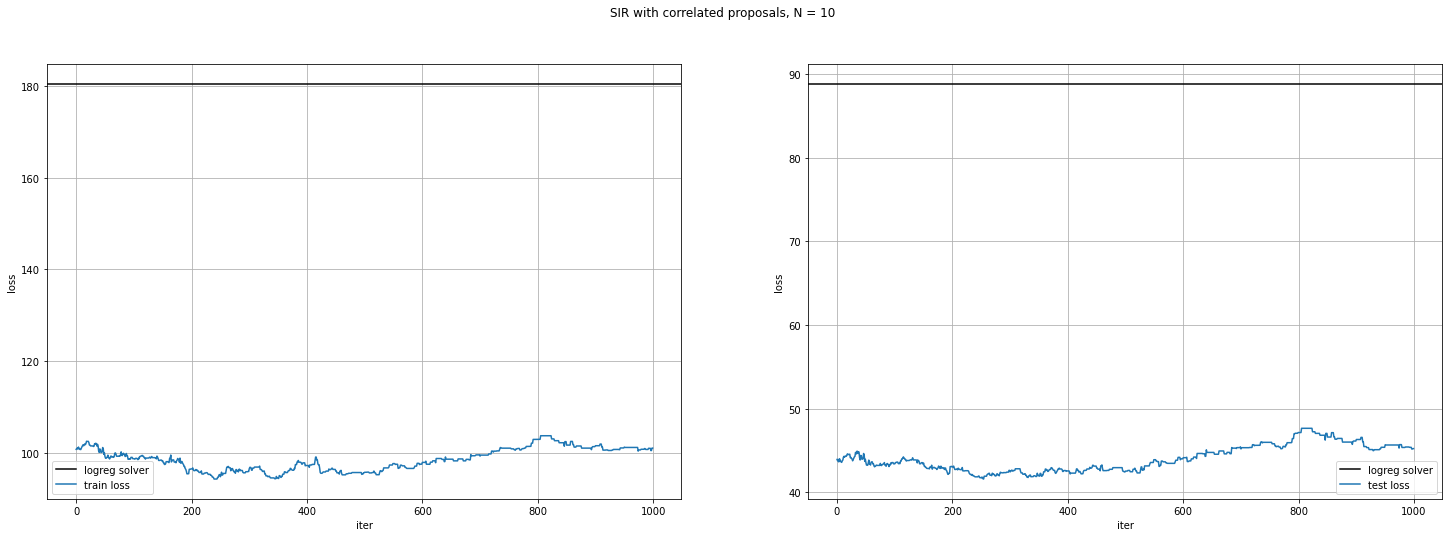

In [336]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'SIR with сorrelated proposals, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [19]:
def sir_independent_dynamics_logreg(z, target, proposal, n_steps, N,
                                    X_train, X_test,
                                    y_train, y_test):
    z_sp = []
    loss_train = []
    loss_test = []
    
    batch_size, z_dim = z.shape[0], z.shape[1]

    for _ in range(n_steps):
        z_sp.append(z)
        U = torch.randint(0, N, (batch_size,)).tolist()
        X = proposal.sample([batch_size, N])
        X[np.arange(batch_size), U, :] = z
        X_view = X.view(-1, z_dim)

        log_weight = compute_sir_log_weights(X_view, target, proposal)
        log_weight = log_weight.view(batch_size, N)
        
        max_logs = torch.max(log_weight, dim = 1)[0][:, None]
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim = 1)
        weight = weight/sum_weight[:, None]

        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()

        z = X[np.arange(batch_size), indices, :]
        z = z.data
        
        train_loss = target.func(z, X_train, y_train).item()
        test_loss = target.func(z, X_test, y_test).item()

        loss_train.append(train_loss)
        loss_test.append(test_loss)

        print('Iter: %d, Training loss: %f, Test loss %f' % (_,
                                                             loss_train[-1], 
                                                             loss_test[-1]))

    z_sp.append(z)
    return z_sp, loss_train, loss_test

In [24]:
device = 'cpu'
scale_proposal = 1
random_seed = 42
dim = X_train.shape[1]
proposal = init_independent_normal(scale_proposal, dim, device)
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
n_steps = 10000
N = 10
batch_size = 1
start = proposal.sample([batch_size])

In [25]:
history, loss_train, loss_test = sir_independent_dynamics_logreg(start, 
                                                                 target,
                                                                 proposal, 
                                                                 n_steps, 
                                                                 N,
                                                                 X_train, X_test,
                                                                 y_train, y_test)

Iter: 0, Training loss: 141.153763, Test loss 77.138306
Iter: 1, Training loss: 141.153763, Test loss 77.138306
Iter: 2, Training loss: 145.321274, Test loss 77.311996
Iter: 3, Training loss: 145.321274, Test loss 77.311996
Iter: 4, Training loss: 134.760864, Test loss 81.387375
Iter: 5, Training loss: 134.760864, Test loss 81.387375
Iter: 6, Training loss: 134.760864, Test loss 81.387375
Iter: 7, Training loss: 142.066727, Test loss 79.866226
Iter: 8, Training loss: 142.066727, Test loss 79.866226
Iter: 9, Training loss: 142.066727, Test loss 79.866226
Iter: 10, Training loss: 142.066727, Test loss 79.866226
Iter: 11, Training loss: 142.066727, Test loss 79.866226
Iter: 12, Training loss: 142.066727, Test loss 79.866226
Iter: 13, Training loss: 142.066727, Test loss 79.866226
Iter: 14, Training loss: 142.066727, Test loss 79.866226
Iter: 15, Training loss: 142.066727, Test loss 79.866226
Iter: 16, Training loss: 142.066727, Test loss 79.866226
Iter: 17, Training loss: 142.066727, Test

Iter: 318, Training loss: 109.177238, Test loss 58.585869
Iter: 319, Training loss: 109.177238, Test loss 58.585869
Iter: 320, Training loss: 109.177238, Test loss 58.585869
Iter: 321, Training loss: 109.177238, Test loss 58.585869
Iter: 322, Training loss: 109.177238, Test loss 58.585869
Iter: 323, Training loss: 109.177238, Test loss 58.585869
Iter: 324, Training loss: 109.177238, Test loss 58.585869
Iter: 325, Training loss: 109.177238, Test loss 58.585869
Iter: 326, Training loss: 109.177238, Test loss 58.585869
Iter: 327, Training loss: 109.177238, Test loss 58.585869
Iter: 328, Training loss: 109.177238, Test loss 58.585869
Iter: 329, Training loss: 109.177238, Test loss 58.585869
Iter: 330, Training loss: 109.177238, Test loss 58.585869
Iter: 331, Training loss: 109.177238, Test loss 58.585869
Iter: 332, Training loss: 109.177238, Test loss 58.585869
Iter: 333, Training loss: 109.177238, Test loss 58.585869
Iter: 334, Training loss: 109.177238, Test loss 58.585869
Iter: 335, Tra

Iter: 601, Training loss: 109.177238, Test loss 58.585869
Iter: 602, Training loss: 109.177238, Test loss 58.585869
Iter: 603, Training loss: 109.177238, Test loss 58.585869
Iter: 604, Training loss: 109.177238, Test loss 58.585869
Iter: 605, Training loss: 109.177238, Test loss 58.585869
Iter: 606, Training loss: 109.177238, Test loss 58.585869
Iter: 607, Training loss: 109.177238, Test loss 58.585869
Iter: 608, Training loss: 109.177238, Test loss 58.585869
Iter: 609, Training loss: 109.177238, Test loss 58.585869
Iter: 610, Training loss: 109.177238, Test loss 58.585869
Iter: 611, Training loss: 109.177238, Test loss 58.585869
Iter: 612, Training loss: 109.177238, Test loss 58.585869
Iter: 613, Training loss: 109.177238, Test loss 58.585869
Iter: 614, Training loss: 109.177238, Test loss 58.585869
Iter: 615, Training loss: 109.177238, Test loss 58.585869
Iter: 616, Training loss: 109.177238, Test loss 58.585869
Iter: 617, Training loss: 109.177238, Test loss 58.585869
Iter: 618, Tra

Iter: 891, Training loss: 105.086777, Test loss 59.959793
Iter: 892, Training loss: 105.086777, Test loss 59.959793
Iter: 893, Training loss: 105.086777, Test loss 59.959793
Iter: 894, Training loss: 105.086777, Test loss 59.959793
Iter: 895, Training loss: 105.086777, Test loss 59.959793
Iter: 896, Training loss: 105.086777, Test loss 59.959793
Iter: 897, Training loss: 105.086777, Test loss 59.959793
Iter: 898, Training loss: 105.086777, Test loss 59.959793
Iter: 899, Training loss: 105.086777, Test loss 59.959793
Iter: 900, Training loss: 105.086777, Test loss 59.959793
Iter: 901, Training loss: 105.086777, Test loss 59.959793
Iter: 902, Training loss: 105.086777, Test loss 59.959793
Iter: 903, Training loss: 105.086777, Test loss 59.959793
Iter: 904, Training loss: 105.086777, Test loss 59.959793
Iter: 905, Training loss: 105.086777, Test loss 59.959793
Iter: 906, Training loss: 105.086777, Test loss 59.959793
Iter: 907, Training loss: 105.086777, Test loss 59.959793
Iter: 908, Tra

Iter: 1133, Training loss: 114.462418, Test loss 65.668861
Iter: 1134, Training loss: 114.462418, Test loss 65.668861
Iter: 1135, Training loss: 114.462418, Test loss 65.668861
Iter: 1136, Training loss: 114.462418, Test loss 65.668861
Iter: 1137, Training loss: 114.462418, Test loss 65.668861
Iter: 1138, Training loss: 114.462418, Test loss 65.668861
Iter: 1139, Training loss: 114.462418, Test loss 65.668861
Iter: 1140, Training loss: 114.462418, Test loss 65.668861
Iter: 1141, Training loss: 114.462418, Test loss 65.668861
Iter: 1142, Training loss: 114.462418, Test loss 65.668861
Iter: 1143, Training loss: 114.462418, Test loss 65.668861
Iter: 1144, Training loss: 114.462418, Test loss 65.668861
Iter: 1145, Training loss: 114.462418, Test loss 65.668861
Iter: 1146, Training loss: 114.462418, Test loss 65.668861
Iter: 1147, Training loss: 114.462418, Test loss 65.668861
Iter: 1148, Training loss: 114.462418, Test loss 65.668861
Iter: 1149, Training loss: 114.462418, Test loss 65.6688

Iter: 1355, Training loss: 112.809189, Test loss 63.855541
Iter: 1356, Training loss: 112.809189, Test loss 63.855541
Iter: 1357, Training loss: 112.809189, Test loss 63.855541
Iter: 1358, Training loss: 112.809189, Test loss 63.855541
Iter: 1359, Training loss: 112.809189, Test loss 63.855541
Iter: 1360, Training loss: 112.809189, Test loss 63.855541
Iter: 1361, Training loss: 112.809189, Test loss 63.855541
Iter: 1362, Training loss: 112.809189, Test loss 63.855541
Iter: 1363, Training loss: 112.809189, Test loss 63.855541
Iter: 1364, Training loss: 112.809189, Test loss 63.855541
Iter: 1365, Training loss: 112.809189, Test loss 63.855541
Iter: 1366, Training loss: 112.809189, Test loss 63.855541
Iter: 1367, Training loss: 112.809189, Test loss 63.855541
Iter: 1368, Training loss: 112.809189, Test loss 63.855541
Iter: 1369, Training loss: 112.809189, Test loss 63.855541
Iter: 1370, Training loss: 112.809189, Test loss 63.855541
Iter: 1371, Training loss: 112.809189, Test loss 63.8555

Iter: 1647, Training loss: 111.212578, Test loss 63.510696
Iter: 1648, Training loss: 111.212578, Test loss 63.510696
Iter: 1649, Training loss: 111.212578, Test loss 63.510696
Iter: 1650, Training loss: 111.212578, Test loss 63.510696
Iter: 1651, Training loss: 111.212578, Test loss 63.510696
Iter: 1652, Training loss: 111.212578, Test loss 63.510696
Iter: 1653, Training loss: 111.212578, Test loss 63.510696
Iter: 1654, Training loss: 111.212578, Test loss 63.510696
Iter: 1655, Training loss: 111.212578, Test loss 63.510696
Iter: 1656, Training loss: 111.212578, Test loss 63.510696
Iter: 1657, Training loss: 111.212578, Test loss 63.510696
Iter: 1658, Training loss: 111.212578, Test loss 63.510696
Iter: 1659, Training loss: 111.212578, Test loss 63.510696
Iter: 1660, Training loss: 111.212578, Test loss 63.510696
Iter: 1661, Training loss: 111.212578, Test loss 63.510696
Iter: 1662, Training loss: 111.212578, Test loss 63.510696
Iter: 1663, Training loss: 111.212578, Test loss 63.5106

Iter: 1942, Training loss: 111.212578, Test loss 63.510696
Iter: 1943, Training loss: 111.212578, Test loss 63.510696
Iter: 1944, Training loss: 111.212578, Test loss 63.510696
Iter: 1945, Training loss: 111.212578, Test loss 63.510696
Iter: 1946, Training loss: 111.212578, Test loss 63.510696
Iter: 1947, Training loss: 111.212578, Test loss 63.510696
Iter: 1948, Training loss: 111.212578, Test loss 63.510696
Iter: 1949, Training loss: 111.212578, Test loss 63.510696
Iter: 1950, Training loss: 111.212578, Test loss 63.510696
Iter: 1951, Training loss: 111.212578, Test loss 63.510696
Iter: 1952, Training loss: 111.212578, Test loss 63.510696
Iter: 1953, Training loss: 111.212578, Test loss 63.510696
Iter: 1954, Training loss: 111.212578, Test loss 63.510696
Iter: 1955, Training loss: 111.212578, Test loss 63.510696
Iter: 1956, Training loss: 111.212578, Test loss 63.510696
Iter: 1957, Training loss: 111.212578, Test loss 63.510696
Iter: 1958, Training loss: 111.212578, Test loss 63.5106

Iter: 2240, Training loss: 111.212578, Test loss 63.510696
Iter: 2241, Training loss: 111.212578, Test loss 63.510696
Iter: 2242, Training loss: 111.212578, Test loss 63.510696
Iter: 2243, Training loss: 111.212578, Test loss 63.510696
Iter: 2244, Training loss: 111.212578, Test loss 63.510696
Iter: 2245, Training loss: 111.212578, Test loss 63.510696
Iter: 2246, Training loss: 111.212578, Test loss 63.510696
Iter: 2247, Training loss: 111.212578, Test loss 63.510696
Iter: 2248, Training loss: 111.212578, Test loss 63.510696
Iter: 2249, Training loss: 111.212578, Test loss 63.510696
Iter: 2250, Training loss: 111.212578, Test loss 63.510696
Iter: 2251, Training loss: 111.212578, Test loss 63.510696
Iter: 2252, Training loss: 111.212578, Test loss 63.510696
Iter: 2253, Training loss: 111.212578, Test loss 63.510696
Iter: 2254, Training loss: 111.212578, Test loss 63.510696
Iter: 2255, Training loss: 111.212578, Test loss 63.510696
Iter: 2256, Training loss: 111.212578, Test loss 63.5106

Iter: 2528, Training loss: 111.212578, Test loss 63.510696
Iter: 2529, Training loss: 111.212578, Test loss 63.510696
Iter: 2530, Training loss: 111.212578, Test loss 63.510696
Iter: 2531, Training loss: 111.212578, Test loss 63.510696
Iter: 2532, Training loss: 111.212578, Test loss 63.510696
Iter: 2533, Training loss: 111.212578, Test loss 63.510696
Iter: 2534, Training loss: 111.212578, Test loss 63.510696
Iter: 2535, Training loss: 111.212578, Test loss 63.510696
Iter: 2536, Training loss: 111.212578, Test loss 63.510696
Iter: 2537, Training loss: 111.212578, Test loss 63.510696
Iter: 2538, Training loss: 111.212578, Test loss 63.510696
Iter: 2539, Training loss: 111.212578, Test loss 63.510696
Iter: 2540, Training loss: 111.212578, Test loss 63.510696
Iter: 2541, Training loss: 111.212578, Test loss 63.510696
Iter: 2542, Training loss: 111.212578, Test loss 63.510696
Iter: 2543, Training loss: 111.212578, Test loss 63.510696
Iter: 2544, Training loss: 111.212578, Test loss 63.5106

Iter: 2817, Training loss: 111.212578, Test loss 63.510696
Iter: 2818, Training loss: 111.212578, Test loss 63.510696
Iter: 2819, Training loss: 111.212578, Test loss 63.510696
Iter: 2820, Training loss: 111.212578, Test loss 63.510696
Iter: 2821, Training loss: 111.212578, Test loss 63.510696
Iter: 2822, Training loss: 111.212578, Test loss 63.510696
Iter: 2823, Training loss: 111.212578, Test loss 63.510696
Iter: 2824, Training loss: 111.212578, Test loss 63.510696
Iter: 2825, Training loss: 111.212578, Test loss 63.510696
Iter: 2826, Training loss: 111.212578, Test loss 63.510696
Iter: 2827, Training loss: 111.212578, Test loss 63.510696
Iter: 2828, Training loss: 111.212578, Test loss 63.510696
Iter: 2829, Training loss: 111.212578, Test loss 63.510696
Iter: 2830, Training loss: 111.212578, Test loss 63.510696
Iter: 2831, Training loss: 111.212578, Test loss 63.510696
Iter: 2832, Training loss: 111.212578, Test loss 63.510696
Iter: 2833, Training loss: 111.212578, Test loss 63.5106

Iter: 3051, Training loss: 111.212578, Test loss 63.510696
Iter: 3052, Training loss: 111.212578, Test loss 63.510696
Iter: 3053, Training loss: 111.212578, Test loss 63.510696
Iter: 3054, Training loss: 111.212578, Test loss 63.510696
Iter: 3055, Training loss: 111.212578, Test loss 63.510696
Iter: 3056, Training loss: 111.212578, Test loss 63.510696
Iter: 3057, Training loss: 111.212578, Test loss 63.510696
Iter: 3058, Training loss: 111.212578, Test loss 63.510696
Iter: 3059, Training loss: 111.212578, Test loss 63.510696
Iter: 3060, Training loss: 111.212578, Test loss 63.510696
Iter: 3061, Training loss: 111.212578, Test loss 63.510696
Iter: 3062, Training loss: 111.212578, Test loss 63.510696
Iter: 3063, Training loss: 111.212578, Test loss 63.510696
Iter: 3064, Training loss: 111.212578, Test loss 63.510696
Iter: 3065, Training loss: 111.212578, Test loss 63.510696
Iter: 3066, Training loss: 111.212578, Test loss 63.510696
Iter: 3067, Training loss: 111.212578, Test loss 63.5106

Iter: 3269, Training loss: 111.212578, Test loss 63.510696
Iter: 3270, Training loss: 111.212578, Test loss 63.510696
Iter: 3271, Training loss: 111.212578, Test loss 63.510696
Iter: 3272, Training loss: 111.212578, Test loss 63.510696
Iter: 3273, Training loss: 111.212578, Test loss 63.510696
Iter: 3274, Training loss: 111.212578, Test loss 63.510696
Iter: 3275, Training loss: 111.212578, Test loss 63.510696
Iter: 3276, Training loss: 111.212578, Test loss 63.510696
Iter: 3277, Training loss: 111.212578, Test loss 63.510696
Iter: 3278, Training loss: 111.212578, Test loss 63.510696
Iter: 3279, Training loss: 111.212578, Test loss 63.510696
Iter: 3280, Training loss: 111.212578, Test loss 63.510696
Iter: 3281, Training loss: 111.212578, Test loss 63.510696
Iter: 3282, Training loss: 111.212578, Test loss 63.510696
Iter: 3283, Training loss: 111.212578, Test loss 63.510696
Iter: 3284, Training loss: 111.212578, Test loss 63.510696
Iter: 3285, Training loss: 111.212578, Test loss 63.5106

Iter: 3500, Training loss: 111.212578, Test loss 63.510696
Iter: 3501, Training loss: 111.212578, Test loss 63.510696
Iter: 3502, Training loss: 111.212578, Test loss 63.510696
Iter: 3503, Training loss: 111.212578, Test loss 63.510696
Iter: 3504, Training loss: 111.212578, Test loss 63.510696
Iter: 3505, Training loss: 111.212578, Test loss 63.510696
Iter: 3506, Training loss: 111.212578, Test loss 63.510696
Iter: 3507, Training loss: 111.212578, Test loss 63.510696
Iter: 3508, Training loss: 111.212578, Test loss 63.510696
Iter: 3509, Training loss: 111.212578, Test loss 63.510696
Iter: 3510, Training loss: 111.212578, Test loss 63.510696
Iter: 3511, Training loss: 111.212578, Test loss 63.510696
Iter: 3512, Training loss: 111.212578, Test loss 63.510696
Iter: 3513, Training loss: 111.212578, Test loss 63.510696
Iter: 3514, Training loss: 111.212578, Test loss 63.510696
Iter: 3515, Training loss: 111.212578, Test loss 63.510696
Iter: 3516, Training loss: 111.212578, Test loss 63.5106

Iter: 3718, Training loss: 111.212578, Test loss 63.510696
Iter: 3719, Training loss: 111.212578, Test loss 63.510696
Iter: 3720, Training loss: 111.212578, Test loss 63.510696
Iter: 3721, Training loss: 111.212578, Test loss 63.510696
Iter: 3722, Training loss: 111.212578, Test loss 63.510696
Iter: 3723, Training loss: 111.212578, Test loss 63.510696
Iter: 3724, Training loss: 111.212578, Test loss 63.510696
Iter: 3725, Training loss: 111.212578, Test loss 63.510696
Iter: 3726, Training loss: 111.212578, Test loss 63.510696
Iter: 3727, Training loss: 111.212578, Test loss 63.510696
Iter: 3728, Training loss: 111.212578, Test loss 63.510696
Iter: 3729, Training loss: 111.212578, Test loss 63.510696
Iter: 3730, Training loss: 111.212578, Test loss 63.510696
Iter: 3731, Training loss: 111.212578, Test loss 63.510696
Iter: 3732, Training loss: 111.212578, Test loss 63.510696
Iter: 3733, Training loss: 111.212578, Test loss 63.510696
Iter: 3734, Training loss: 111.212578, Test loss 63.5106

Iter: 3939, Training loss: 111.212578, Test loss 63.510696
Iter: 3940, Training loss: 111.212578, Test loss 63.510696
Iter: 3941, Training loss: 111.212578, Test loss 63.510696
Iter: 3942, Training loss: 111.212578, Test loss 63.510696
Iter: 3943, Training loss: 111.212578, Test loss 63.510696
Iter: 3944, Training loss: 111.212578, Test loss 63.510696
Iter: 3945, Training loss: 111.212578, Test loss 63.510696
Iter: 3946, Training loss: 111.212578, Test loss 63.510696
Iter: 3947, Training loss: 111.212578, Test loss 63.510696
Iter: 3948, Training loss: 111.212578, Test loss 63.510696
Iter: 3949, Training loss: 111.212578, Test loss 63.510696
Iter: 3950, Training loss: 111.212578, Test loss 63.510696
Iter: 3951, Training loss: 111.212578, Test loss 63.510696
Iter: 3952, Training loss: 111.212578, Test loss 63.510696
Iter: 3953, Training loss: 111.212578, Test loss 63.510696
Iter: 3954, Training loss: 111.212578, Test loss 63.510696
Iter: 3955, Training loss: 111.212578, Test loss 63.5106

Iter: 4182, Training loss: 110.296074, Test loss 65.612427
Iter: 4183, Training loss: 110.296074, Test loss 65.612427
Iter: 4184, Training loss: 110.296074, Test loss 65.612427
Iter: 4185, Training loss: 110.296074, Test loss 65.612427
Iter: 4186, Training loss: 110.296074, Test loss 65.612427
Iter: 4187, Training loss: 110.296074, Test loss 65.612427
Iter: 4188, Training loss: 110.296074, Test loss 65.612427
Iter: 4189, Training loss: 110.296074, Test loss 65.612427
Iter: 4190, Training loss: 110.296074, Test loss 65.612427
Iter: 4191, Training loss: 110.296074, Test loss 65.612427
Iter: 4192, Training loss: 110.296074, Test loss 65.612427
Iter: 4193, Training loss: 110.296074, Test loss 65.612427
Iter: 4194, Training loss: 110.296074, Test loss 65.612427
Iter: 4195, Training loss: 110.296074, Test loss 65.612427
Iter: 4196, Training loss: 110.296074, Test loss 65.612427
Iter: 4197, Training loss: 110.296074, Test loss 65.612427
Iter: 4198, Training loss: 110.296074, Test loss 65.6124

Iter: 4429, Training loss: 110.296074, Test loss 65.612427
Iter: 4430, Training loss: 110.296074, Test loss 65.612427
Iter: 4431, Training loss: 110.296074, Test loss 65.612427
Iter: 4432, Training loss: 110.296074, Test loss 65.612427
Iter: 4433, Training loss: 110.296074, Test loss 65.612427
Iter: 4434, Training loss: 110.296074, Test loss 65.612427
Iter: 4435, Training loss: 110.296074, Test loss 65.612427
Iter: 4436, Training loss: 110.296074, Test loss 65.612427
Iter: 4437, Training loss: 110.296074, Test loss 65.612427
Iter: 4438, Training loss: 110.296074, Test loss 65.612427
Iter: 4439, Training loss: 110.296074, Test loss 65.612427
Iter: 4440, Training loss: 110.296074, Test loss 65.612427
Iter: 4441, Training loss: 110.296074, Test loss 65.612427
Iter: 4442, Training loss: 110.296074, Test loss 65.612427
Iter: 4443, Training loss: 110.296074, Test loss 65.612427
Iter: 4444, Training loss: 110.296074, Test loss 65.612427
Iter: 4445, Training loss: 110.296074, Test loss 65.6124

Iter: 4646, Training loss: 110.296074, Test loss 65.612427
Iter: 4647, Training loss: 110.296074, Test loss 65.612427
Iter: 4648, Training loss: 110.296074, Test loss 65.612427
Iter: 4649, Training loss: 110.296074, Test loss 65.612427
Iter: 4650, Training loss: 110.296074, Test loss 65.612427
Iter: 4651, Training loss: 110.296074, Test loss 65.612427
Iter: 4652, Training loss: 110.296074, Test loss 65.612427
Iter: 4653, Training loss: 110.296074, Test loss 65.612427
Iter: 4654, Training loss: 110.296074, Test loss 65.612427
Iter: 4655, Training loss: 110.296074, Test loss 65.612427
Iter: 4656, Training loss: 110.296074, Test loss 65.612427
Iter: 4657, Training loss: 110.296074, Test loss 65.612427
Iter: 4658, Training loss: 110.296074, Test loss 65.612427
Iter: 4659, Training loss: 110.296074, Test loss 65.612427
Iter: 4660, Training loss: 110.296074, Test loss 65.612427
Iter: 4661, Training loss: 110.296074, Test loss 65.612427
Iter: 4662, Training loss: 110.296074, Test loss 65.6124

Iter: 4890, Training loss: 110.296074, Test loss 65.612427
Iter: 4891, Training loss: 110.296074, Test loss 65.612427
Iter: 4892, Training loss: 110.296074, Test loss 65.612427
Iter: 4893, Training loss: 110.296074, Test loss 65.612427
Iter: 4894, Training loss: 110.296074, Test loss 65.612427
Iter: 4895, Training loss: 110.296074, Test loss 65.612427
Iter: 4896, Training loss: 110.296074, Test loss 65.612427
Iter: 4897, Training loss: 110.296074, Test loss 65.612427
Iter: 4898, Training loss: 110.296074, Test loss 65.612427
Iter: 4899, Training loss: 110.296074, Test loss 65.612427
Iter: 4900, Training loss: 110.296074, Test loss 65.612427
Iter: 4901, Training loss: 110.296074, Test loss 65.612427
Iter: 4902, Training loss: 110.296074, Test loss 65.612427
Iter: 4903, Training loss: 110.296074, Test loss 65.612427
Iter: 4904, Training loss: 110.296074, Test loss 65.612427
Iter: 4905, Training loss: 110.296074, Test loss 65.612427
Iter: 4906, Training loss: 110.296074, Test loss 65.6124

Iter: 5168, Training loss: 110.296074, Test loss 65.612427
Iter: 5169, Training loss: 110.296074, Test loss 65.612427
Iter: 5170, Training loss: 110.296074, Test loss 65.612427
Iter: 5171, Training loss: 110.296074, Test loss 65.612427
Iter: 5172, Training loss: 110.296074, Test loss 65.612427
Iter: 5173, Training loss: 110.296074, Test loss 65.612427
Iter: 5174, Training loss: 110.296074, Test loss 65.612427
Iter: 5175, Training loss: 110.296074, Test loss 65.612427
Iter: 5176, Training loss: 110.296074, Test loss 65.612427
Iter: 5177, Training loss: 110.296074, Test loss 65.612427
Iter: 5178, Training loss: 110.296074, Test loss 65.612427
Iter: 5179, Training loss: 110.296074, Test loss 65.612427
Iter: 5180, Training loss: 110.296074, Test loss 65.612427
Iter: 5181, Training loss: 110.296074, Test loss 65.612427
Iter: 5182, Training loss: 110.296074, Test loss 65.612427
Iter: 5183, Training loss: 110.296074, Test loss 65.612427
Iter: 5184, Training loss: 110.296074, Test loss 65.6124

Iter: 5460, Training loss: 110.296074, Test loss 65.612427
Iter: 5461, Training loss: 110.296074, Test loss 65.612427
Iter: 5462, Training loss: 110.296074, Test loss 65.612427
Iter: 5463, Training loss: 110.296074, Test loss 65.612427
Iter: 5464, Training loss: 110.296074, Test loss 65.612427
Iter: 5465, Training loss: 110.296074, Test loss 65.612427
Iter: 5466, Training loss: 110.296074, Test loss 65.612427
Iter: 5467, Training loss: 110.296074, Test loss 65.612427
Iter: 5468, Training loss: 110.296074, Test loss 65.612427
Iter: 5469, Training loss: 110.296074, Test loss 65.612427
Iter: 5470, Training loss: 110.296074, Test loss 65.612427
Iter: 5471, Training loss: 110.296074, Test loss 65.612427
Iter: 5472, Training loss: 110.296074, Test loss 65.612427
Iter: 5473, Training loss: 110.296074, Test loss 65.612427
Iter: 5474, Training loss: 110.296074, Test loss 65.612427
Iter: 5475, Training loss: 110.296074, Test loss 65.612427
Iter: 5476, Training loss: 110.296074, Test loss 65.6124

Iter: 5747, Training loss: 116.254356, Test loss 67.732819
Iter: 5748, Training loss: 116.254356, Test loss 67.732819
Iter: 5749, Training loss: 116.254356, Test loss 67.732819
Iter: 5750, Training loss: 116.254356, Test loss 67.732819
Iter: 5751, Training loss: 116.254356, Test loss 67.732819
Iter: 5752, Training loss: 116.254356, Test loss 67.732819
Iter: 5753, Training loss: 116.254356, Test loss 67.732819
Iter: 5754, Training loss: 116.254356, Test loss 67.732819
Iter: 5755, Training loss: 116.254356, Test loss 67.732819
Iter: 5756, Training loss: 116.254356, Test loss 67.732819
Iter: 5757, Training loss: 116.254356, Test loss 67.732819
Iter: 5758, Training loss: 116.254356, Test loss 67.732819
Iter: 5759, Training loss: 116.254356, Test loss 67.732819
Iter: 5760, Training loss: 116.254356, Test loss 67.732819
Iter: 5761, Training loss: 116.254356, Test loss 67.732819
Iter: 5762, Training loss: 116.254356, Test loss 67.732819
Iter: 5763, Training loss: 116.254356, Test loss 67.7328

Iter: 6042, Training loss: 117.464195, Test loss 69.982666
Iter: 6043, Training loss: 117.464195, Test loss 69.982666
Iter: 6044, Training loss: 117.464195, Test loss 69.982666
Iter: 6045, Training loss: 117.464195, Test loss 69.982666
Iter: 6046, Training loss: 117.464195, Test loss 69.982666
Iter: 6047, Training loss: 117.464195, Test loss 69.982666
Iter: 6048, Training loss: 117.464195, Test loss 69.982666
Iter: 6049, Training loss: 117.464195, Test loss 69.982666
Iter: 6050, Training loss: 117.464195, Test loss 69.982666
Iter: 6051, Training loss: 117.464195, Test loss 69.982666
Iter: 6052, Training loss: 117.464195, Test loss 69.982666
Iter: 6053, Training loss: 117.464195, Test loss 69.982666
Iter: 6054, Training loss: 117.464195, Test loss 69.982666
Iter: 6055, Training loss: 117.464195, Test loss 69.982666
Iter: 6056, Training loss: 117.464195, Test loss 69.982666
Iter: 6057, Training loss: 117.464195, Test loss 69.982666
Iter: 6058, Training loss: 117.464195, Test loss 69.9826

Iter: 6327, Training loss: 122.271973, Test loss 73.063370
Iter: 6328, Training loss: 122.271973, Test loss 73.063370
Iter: 6329, Training loss: 122.271973, Test loss 73.063370
Iter: 6330, Training loss: 122.271973, Test loss 73.063370
Iter: 6331, Training loss: 122.271973, Test loss 73.063370
Iter: 6332, Training loss: 122.271973, Test loss 73.063370
Iter: 6333, Training loss: 122.271973, Test loss 73.063370
Iter: 6334, Training loss: 122.271973, Test loss 73.063370
Iter: 6335, Training loss: 122.271973, Test loss 73.063370
Iter: 6336, Training loss: 122.271973, Test loss 73.063370
Iter: 6337, Training loss: 122.271973, Test loss 73.063370
Iter: 6338, Training loss: 122.271973, Test loss 73.063370
Iter: 6339, Training loss: 122.271973, Test loss 73.063370
Iter: 6340, Training loss: 122.271973, Test loss 73.063370
Iter: 6341, Training loss: 122.271973, Test loss 73.063370
Iter: 6342, Training loss: 122.271973, Test loss 73.063370
Iter: 6343, Training loss: 122.271973, Test loss 73.0633

Iter: 6612, Training loss: 122.271973, Test loss 73.063370
Iter: 6613, Training loss: 122.271973, Test loss 73.063370
Iter: 6614, Training loss: 122.271973, Test loss 73.063370
Iter: 6615, Training loss: 122.271973, Test loss 73.063370
Iter: 6616, Training loss: 122.271973, Test loss 73.063370
Iter: 6617, Training loss: 122.271973, Test loss 73.063370
Iter: 6618, Training loss: 122.271973, Test loss 73.063370
Iter: 6619, Training loss: 122.271973, Test loss 73.063370
Iter: 6620, Training loss: 122.271973, Test loss 73.063370
Iter: 6621, Training loss: 122.271973, Test loss 73.063370
Iter: 6622, Training loss: 122.271973, Test loss 73.063370
Iter: 6623, Training loss: 122.271973, Test loss 73.063370
Iter: 6624, Training loss: 122.271973, Test loss 73.063370
Iter: 6625, Training loss: 122.271973, Test loss 73.063370
Iter: 6626, Training loss: 122.271973, Test loss 73.063370
Iter: 6627, Training loss: 117.935539, Test loss 71.327660
Iter: 6628, Training loss: 117.935539, Test loss 71.3276

Iter: 6905, Training loss: 114.217934, Test loss 58.526276
Iter: 6906, Training loss: 114.217934, Test loss 58.526276
Iter: 6907, Training loss: 114.217934, Test loss 58.526276
Iter: 6908, Training loss: 114.217934, Test loss 58.526276
Iter: 6909, Training loss: 114.217934, Test loss 58.526276
Iter: 6910, Training loss: 114.217934, Test loss 58.526276
Iter: 6911, Training loss: 114.217934, Test loss 58.526276
Iter: 6912, Training loss: 114.217934, Test loss 58.526276
Iter: 6913, Training loss: 114.217934, Test loss 58.526276
Iter: 6914, Training loss: 114.217934, Test loss 58.526276
Iter: 6915, Training loss: 114.217934, Test loss 58.526276
Iter: 6916, Training loss: 114.217934, Test loss 58.526276
Iter: 6917, Training loss: 114.217934, Test loss 58.526276
Iter: 6918, Training loss: 114.217934, Test loss 58.526276
Iter: 6919, Training loss: 114.217934, Test loss 58.526276
Iter: 6920, Training loss: 114.217934, Test loss 58.526276
Iter: 6921, Training loss: 114.217934, Test loss 58.5262

Iter: 7206, Training loss: 120.360229, Test loss 71.421188
Iter: 7207, Training loss: 120.360229, Test loss 71.421188
Iter: 7208, Training loss: 120.360229, Test loss 71.421188
Iter: 7209, Training loss: 120.360229, Test loss 71.421188
Iter: 7210, Training loss: 120.360229, Test loss 71.421188
Iter: 7211, Training loss: 120.360229, Test loss 71.421188
Iter: 7212, Training loss: 120.360229, Test loss 71.421188
Iter: 7213, Training loss: 120.360229, Test loss 71.421188
Iter: 7214, Training loss: 120.360229, Test loss 71.421188
Iter: 7215, Training loss: 120.360229, Test loss 71.421188
Iter: 7216, Training loss: 120.360229, Test loss 71.421188
Iter: 7217, Training loss: 120.360229, Test loss 71.421188
Iter: 7218, Training loss: 120.360229, Test loss 71.421188
Iter: 7219, Training loss: 120.360229, Test loss 71.421188
Iter: 7220, Training loss: 120.360229, Test loss 71.421188
Iter: 7221, Training loss: 120.360229, Test loss 71.421188
Iter: 7222, Training loss: 120.360229, Test loss 71.4211

Iter: 7500, Training loss: 119.903992, Test loss 73.032425
Iter: 7501, Training loss: 119.903992, Test loss 73.032425
Iter: 7502, Training loss: 119.903992, Test loss 73.032425
Iter: 7503, Training loss: 119.903992, Test loss 73.032425
Iter: 7504, Training loss: 119.903992, Test loss 73.032425
Iter: 7505, Training loss: 119.903992, Test loss 73.032425
Iter: 7506, Training loss: 119.903992, Test loss 73.032425
Iter: 7507, Training loss: 119.903992, Test loss 73.032425
Iter: 7508, Training loss: 119.903992, Test loss 73.032425
Iter: 7509, Training loss: 119.903992, Test loss 73.032425
Iter: 7510, Training loss: 119.903992, Test loss 73.032425
Iter: 7511, Training loss: 119.903992, Test loss 73.032425
Iter: 7512, Training loss: 119.903992, Test loss 73.032425
Iter: 7513, Training loss: 119.903992, Test loss 73.032425
Iter: 7514, Training loss: 119.903992, Test loss 73.032425
Iter: 7515, Training loss: 119.903992, Test loss 73.032425
Iter: 7516, Training loss: 119.903992, Test loss 73.0324

Iter: 7808, Training loss: 119.903992, Test loss 73.032425
Iter: 7809, Training loss: 119.903992, Test loss 73.032425
Iter: 7810, Training loss: 119.903992, Test loss 73.032425
Iter: 7811, Training loss: 119.903992, Test loss 73.032425
Iter: 7812, Training loss: 119.903992, Test loss 73.032425
Iter: 7813, Training loss: 119.903992, Test loss 73.032425
Iter: 7814, Training loss: 119.903992, Test loss 73.032425
Iter: 7815, Training loss: 119.903992, Test loss 73.032425
Iter: 7816, Training loss: 119.903992, Test loss 73.032425
Iter: 7817, Training loss: 119.903992, Test loss 73.032425
Iter: 7818, Training loss: 119.903992, Test loss 73.032425
Iter: 7819, Training loss: 119.903992, Test loss 73.032425
Iter: 7820, Training loss: 119.903992, Test loss 73.032425
Iter: 7821, Training loss: 119.903992, Test loss 73.032425
Iter: 7822, Training loss: 119.903992, Test loss 73.032425
Iter: 7823, Training loss: 119.903992, Test loss 73.032425
Iter: 7824, Training loss: 119.903992, Test loss 73.0324

Iter: 8097, Training loss: 119.903992, Test loss 73.032425
Iter: 8098, Training loss: 119.903992, Test loss 73.032425
Iter: 8099, Training loss: 119.903992, Test loss 73.032425
Iter: 8100, Training loss: 119.903992, Test loss 73.032425
Iter: 8101, Training loss: 119.903992, Test loss 73.032425
Iter: 8102, Training loss: 119.903992, Test loss 73.032425
Iter: 8103, Training loss: 119.903992, Test loss 73.032425
Iter: 8104, Training loss: 119.903992, Test loss 73.032425
Iter: 8105, Training loss: 119.903992, Test loss 73.032425
Iter: 8106, Training loss: 119.903992, Test loss 73.032425
Iter: 8107, Training loss: 119.903992, Test loss 73.032425
Iter: 8108, Training loss: 119.903992, Test loss 73.032425
Iter: 8109, Training loss: 119.903992, Test loss 73.032425
Iter: 8110, Training loss: 119.903992, Test loss 73.032425
Iter: 8111, Training loss: 119.903992, Test loss 73.032425
Iter: 8112, Training loss: 119.903992, Test loss 73.032425
Iter: 8113, Training loss: 119.903992, Test loss 73.0324

Iter: 8366, Training loss: 108.932816, Test loss 62.204475
Iter: 8367, Training loss: 108.932816, Test loss 62.204475
Iter: 8368, Training loss: 108.932816, Test loss 62.204475
Iter: 8369, Training loss: 108.932816, Test loss 62.204475
Iter: 8370, Training loss: 108.932816, Test loss 62.204475
Iter: 8371, Training loss: 108.932816, Test loss 62.204475
Iter: 8372, Training loss: 108.932816, Test loss 62.204475
Iter: 8373, Training loss: 108.932816, Test loss 62.204475
Iter: 8374, Training loss: 108.932816, Test loss 62.204475
Iter: 8375, Training loss: 108.932816, Test loss 62.204475
Iter: 8376, Training loss: 108.932816, Test loss 62.204475
Iter: 8377, Training loss: 108.932816, Test loss 62.204475
Iter: 8378, Training loss: 108.932816, Test loss 62.204475
Iter: 8379, Training loss: 108.932816, Test loss 62.204475
Iter: 8380, Training loss: 108.932816, Test loss 62.204475
Iter: 8381, Training loss: 108.932816, Test loss 62.204475
Iter: 8382, Training loss: 108.932816, Test loss 62.2044

Iter: 8655, Training loss: 108.932816, Test loss 62.204475
Iter: 8656, Training loss: 108.932816, Test loss 62.204475
Iter: 8657, Training loss: 108.932816, Test loss 62.204475
Iter: 8658, Training loss: 108.932816, Test loss 62.204475
Iter: 8659, Training loss: 108.932816, Test loss 62.204475
Iter: 8660, Training loss: 108.932816, Test loss 62.204475
Iter: 8661, Training loss: 108.932816, Test loss 62.204475
Iter: 8662, Training loss: 108.932816, Test loss 62.204475
Iter: 8663, Training loss: 108.932816, Test loss 62.204475
Iter: 8664, Training loss: 108.932816, Test loss 62.204475
Iter: 8665, Training loss: 108.932816, Test loss 62.204475
Iter: 8666, Training loss: 108.932816, Test loss 62.204475
Iter: 8667, Training loss: 108.932816, Test loss 62.204475
Iter: 8668, Training loss: 108.932816, Test loss 62.204475
Iter: 8669, Training loss: 108.932816, Test loss 62.204475
Iter: 8670, Training loss: 108.932816, Test loss 62.204475
Iter: 8671, Training loss: 108.932816, Test loss 62.2044

Iter: 8939, Training loss: 109.782578, Test loss 65.147446
Iter: 8940, Training loss: 109.782578, Test loss 65.147446
Iter: 8941, Training loss: 109.782578, Test loss 65.147446
Iter: 8942, Training loss: 109.782578, Test loss 65.147446
Iter: 8943, Training loss: 109.782578, Test loss 65.147446
Iter: 8944, Training loss: 109.782578, Test loss 65.147446
Iter: 8945, Training loss: 109.782578, Test loss 65.147446
Iter: 8946, Training loss: 109.782578, Test loss 65.147446
Iter: 8947, Training loss: 109.782578, Test loss 65.147446
Iter: 8948, Training loss: 109.782578, Test loss 65.147446
Iter: 8949, Training loss: 109.782578, Test loss 65.147446
Iter: 8950, Training loss: 109.782578, Test loss 65.147446
Iter: 8951, Training loss: 109.782578, Test loss 65.147446
Iter: 8952, Training loss: 109.782578, Test loss 65.147446
Iter: 8953, Training loss: 109.782578, Test loss 65.147446
Iter: 8954, Training loss: 109.782578, Test loss 65.147446
Iter: 8955, Training loss: 109.782578, Test loss 65.1474

Iter: 9229, Training loss: 115.752235, Test loss 68.105362
Iter: 9230, Training loss: 115.752235, Test loss 68.105362
Iter: 9231, Training loss: 115.752235, Test loss 68.105362
Iter: 9232, Training loss: 115.752235, Test loss 68.105362
Iter: 9233, Training loss: 115.752235, Test loss 68.105362
Iter: 9234, Training loss: 115.752235, Test loss 68.105362
Iter: 9235, Training loss: 115.752235, Test loss 68.105362
Iter: 9236, Training loss: 115.752235, Test loss 68.105362
Iter: 9237, Training loss: 115.752235, Test loss 68.105362
Iter: 9238, Training loss: 115.752235, Test loss 68.105362
Iter: 9239, Training loss: 115.752235, Test loss 68.105362
Iter: 9240, Training loss: 115.752235, Test loss 68.105362
Iter: 9241, Training loss: 115.752235, Test loss 68.105362
Iter: 9242, Training loss: 115.752235, Test loss 68.105362
Iter: 9243, Training loss: 115.752235, Test loss 68.105362
Iter: 9244, Training loss: 115.752235, Test loss 68.105362
Iter: 9245, Training loss: 115.752235, Test loss 68.1053

Iter: 9519, Training loss: 115.752235, Test loss 68.105362
Iter: 9520, Training loss: 115.752235, Test loss 68.105362
Iter: 9521, Training loss: 115.752235, Test loss 68.105362
Iter: 9522, Training loss: 115.752235, Test loss 68.105362
Iter: 9523, Training loss: 115.752235, Test loss 68.105362
Iter: 9524, Training loss: 115.752235, Test loss 68.105362
Iter: 9525, Training loss: 115.752235, Test loss 68.105362
Iter: 9526, Training loss: 115.752235, Test loss 68.105362
Iter: 9527, Training loss: 115.752235, Test loss 68.105362
Iter: 9528, Training loss: 115.752235, Test loss 68.105362
Iter: 9529, Training loss: 115.752235, Test loss 68.105362
Iter: 9530, Training loss: 115.752235, Test loss 68.105362
Iter: 9531, Training loss: 115.752235, Test loss 68.105362
Iter: 9532, Training loss: 115.752235, Test loss 68.105362
Iter: 9533, Training loss: 115.752235, Test loss 68.105362
Iter: 9534, Training loss: 115.752235, Test loss 68.105362
Iter: 9535, Training loss: 115.752235, Test loss 68.1053

Iter: 9799, Training loss: 110.855736, Test loss 68.210083
Iter: 9800, Training loss: 110.855736, Test loss 68.210083
Iter: 9801, Training loss: 110.855736, Test loss 68.210083
Iter: 9802, Training loss: 110.855736, Test loss 68.210083
Iter: 9803, Training loss: 110.855736, Test loss 68.210083
Iter: 9804, Training loss: 110.855736, Test loss 68.210083
Iter: 9805, Training loss: 110.855736, Test loss 68.210083
Iter: 9806, Training loss: 110.855736, Test loss 68.210083
Iter: 9807, Training loss: 110.855736, Test loss 68.210083
Iter: 9808, Training loss: 110.855736, Test loss 68.210083
Iter: 9809, Training loss: 110.855736, Test loss 68.210083
Iter: 9810, Training loss: 110.855736, Test loss 68.210083
Iter: 9811, Training loss: 110.855736, Test loss 68.210083
Iter: 9812, Training loss: 110.855736, Test loss 68.210083
Iter: 9813, Training loss: 110.855736, Test loss 68.210083
Iter: 9814, Training loss: 110.855736, Test loss 68.210083
Iter: 9815, Training loss: 110.855736, Test loss 68.2100